# "The Entrainment of Air from Rainy Surface Regions and its Implications for Bioaerosol Transport in Three Deep Convective Storm Morphologies" (Davis et al.) analysis notebook

This notebook produces all of the analysis and figures presented in the manuscript named above. Assuming the required RAMS output is present, it should work out of the box (or nearly so),
with only a few possible changes you could need to make, described here:

* The `common` and `blt_utils` packages used throughout are included, and should be found automatically by python. If they are not,
  you can ensure that the appropriate directories/locations are included using `sys.path.append`.
* Assuming you have reproduced the RAMS output, you will need to modify the `RAMS_OUTPUT_DIRS` variable in `blt_utils.py` to point to the
  directories containing the RAMS output for each storm. All other paths are relative and should not need to be adjusted.
* If `USE_DASK_LOCAL_CLUSTER` is set to True, xarray will try to read in the RAMS data using the dask backend. This is set to False
  by default so that the code will work, but if you wish to use dask, start your own scheduler and modify the `DASK_SCHEDULER_ADDRESS`
  variable in `blt_utils.py`
* In the "Read/calculate data"/"Tracer concentration files" and "Read/calculate data"/"Development dataframes" cells below,
  the flags for each storm in the top of the cell can be set to False to recalculate the derived dataset from the raw
  RAMS output. With the default True, these will be read from disk (they are included with the repo).

# Setup

## Imports

In [ ]:
# Native packages
from pathlib import Path
from importlib import reload
import re

# Other packages
import pandas as pd
import xarray as xr
import pint_xarray
import numpy as np
from metpy.plots import SkewT, Hodograph
import metpy.calc as mpc
from metpy.units import units
import metpy.constants as mpconstants
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.animation as mplanim
from matplotlib.animation import FuncAnimation
from matplotlib import cm, ticker
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML, display, Image
from tqdm.notebook import tqdm
import pickle as pkl
from scipy import interpolate

# My packages
import common as cm
import blt_utils as blt

plt.style.use(blt.MPL_STYLE)

## Parameters

In [ ]:
# Explicitly parallelizing over the local machine is similaraly finnicky, so add a flag for it
USE_DASK_LOCAL_CLUSTER = False

display(blt.RAMS_OUTPUT_DIRS)
display(blt.DEVELOPMENT_DATAFRAME_FILEPATHS)
display(blt.TRACER_TOTALS_PROFILE_FILEPATHS)

{'ic_wk': PosixPath('/moonbow/cmdavis4/projects/bl_transport/rams_io/isolated_convection_wk/all_tracers/newtracer_forcing-warmbubble4_deltax-500_frqlite-2_nobulku/output'),
 'sl_wk': PosixPath('/moonbow/cmdavis4/projects/bl_transport/rams_io/squall_line_wk/all_tracers/newtracer_blspinup-no_forcing-infinitecoldbubble4_deltax-500_frqlite-2/output'),
 'sc_wk': PosixPath('/moonbow/cmdavis4/projects/bl_transport/rams_io/supercell_wk/all_tracers/newtracer_forcing-grant2014_dx-500_frqlite-2_stratwinds/output')}

{'ic_wk': PosixPath('/home/cmdavis4/projects/tracer_paper/data/derived/ic_wk/development_dataframe.pkl'),
 'sl_wk': PosixPath('/home/cmdavis4/projects/tracer_paper/data/derived/sl_wk/development_dataframe.pkl'),
 'sc_wk': PosixPath('/home/cmdavis4/projects/tracer_paper/data/derived/sc_wk/development_dataframe.pkl')}

{'ic_wk': PosixPath('/home/cmdavis4/projects/tracer_paper/data/derived/ic_wk/tracer_totals_profile_ds.nc'),
 'sl_wk': PosixPath('/home/cmdavis4/projects/tracer_paper/data/derived/sl_wk/tracer_totals_profile_ds.nc'),
 'sc_wk': PosixPath('/home/cmdavis4/projects/tracer_paper/data/derived/sc_wk/tracer_totals_profile_ds.nc')}

## Dask cluster

In [3]:
if USE_DASK_LOCAL_CLUSTER:
    from dask.distributed import Client

    # The default scheduler port is 8786, but can change this if need be
    client = Client(blt.DASK_SCHEDULER_ADDRESS)

# Read/calculate data

## 5 minute RAMS output

In [5]:
reload(cm.rams)
reload(blt)

# Define the list of RAMS output filenames we'll read in
# Can specify this manually or just use a glob
rams_input_filename_glob = "a-A-*.h5"

rams_input_dim_names_kwargs = (
    {
        "dim_names": {
            "phony_dim_0": "y",
            "phony_dim_1": "x",
            "phony_dim_2": "p",
            "phony_dim_3": "z",
        }
    }
    if rams_input_filename_glob.startswith("a-L")
    else {}
)

storm_dss = {}

for storm_name in tqdm(list(blt.STORM_LABELS.keys())):
    rams_input_filenames = sorted(
        list(blt.RAMS_OUTPUT_DIRS[storm_name].glob(rams_input_filename_glob))
    )

    # Read in the RAMS output
    storm_ds = cm.rams.read_rams_output(
        input_filenames=rams_input_filenames,
        time_dim_name="time",
        units=False,
        **rams_input_dim_names_kwargs,
    )

    # Postprocess
    storm_ds = blt.postprocess_storm_ds(storm_ds, storm_name)

    # Store
    storm_dss[storm_name] = storm_ds


# Calculate the timestep and horizontal grid spacing, assuming they are uniform
# Doesn't matter which storm ds we use
DELTA_T = (storm_ds["time"].values[1] - storm_ds["time"].values[0]) / np.timedelta64(
    1, "s"
)
DELTA_X = storm_ds["x"].values[1] - storm_ds["x"].values[0]

  0%|          | 0/3 [00:00<?, ?it/s]

Reading and concatenating 37 RAMS individual timestep outputs...
Reading and concatenating 37 RAMS individual timestep outputs...
Reading and concatenating 37 RAMS individual timestep outputs...


## Tracer concentration files

In [6]:
reload(blt)

# Whether to read this from disk; if not, it recalculates it and save it to disk
READ_TRACER_CONCENTRATIONS = {"ic_wk": True, "sl_wk": True, "sc_wk": True}

tracer_totals_profile_dss = {}
for storm, storm_ds in storm_dss.items():

    tracer_totals_profile_filepath = blt.TRACER_TOTALS_PROFILE_FILEPATHS[storm]
    print(tracer_totals_profile_filepath)
    # continue
    if READ_TRACER_CONCENTRATIONS[storm]:
        tracer_totals_profile_ds = xr.open_dataset(tracer_totals_profile_filepath)
    else:
        tracer_totals_profile_ds = blt.calculate_tracer_profile_ds(
            storm_ds.where(storm_ds["in_analysis"])
        )
        # Save it to disk
        print("Saving...")
        tracer_totals_profile_ds.to_netcdf(tracer_totals_profile_filepath)
    # Store it
    tracer_totals_profile_dss[storm] = tracer_totals_profile_ds

# Calculate totals across vertical levels
tracer_totals_dss = {
    k: v.isel({"z": slice(1, len(v["z"]))}).sum("z")
    for k, v in tracer_totals_profile_dss.items()
}

/home/cmdavis4/projects/tracer_paper/data/derived/ic_wk/tracer_totals_profile_ds.nc
/home/cmdavis4/projects/tracer_paper/data/derived/sl_wk/tracer_totals_profile_ds.nc
/home/cmdavis4/projects/tracer_paper/data/derived/sc_wk/tracer_totals_profile_ds.nc


## Development dataframes

In [7]:
reload(blt)

READ_DEVELOPMENT_DATAFRAMES = {"ic_wk": True, "sl_wk": True, "sc_wk": True}

development_dfs = {}

for storm, storm_ds in tqdm(storm_dss.items()):

    development_df_filepath = blt.DEVELOPMENT_DATAFRAME_FILEPATHS[storm]
    print(development_df_filepath)

    if READ_DEVELOPMENT_DATAFRAMES[storm]:
        development_df = pd.read_pickle(development_df_filepath)
    else:
        development_df = blt.calculate_development_dataframe(
            storm_ds.where(storm_ds["in_analysis"])
        )
        # Write it to disk
        development_df.to_pickle(development_df_filepath)

    # Store it
    development_dfs[storm] = development_df

    # Attach the storm positions to the storm datasets
    for coord in ["x", "y"]:
        storm_dss[storm][f"storm_position_{coord}"] = xr.DataArray(
            development_df[f"storm_centroid_{coord}"].values,
            coords={
                "time": [
                    blt.minutes_to_simulation_time(x)
                    for x in development_df["t_minutes"].values
                ]
            },
        )

  0%|          | 0/3 [00:00<?, ?it/s]

/home/cmdavis4/projects/tracer_paper/data/derived/ic_wk/development_dataframe.pkl
/home/cmdavis4/projects/tracer_paper/data/derived/sl_wk/development_dataframe.pkl
/home/cmdavis4/projects/tracer_paper/data/derived/sc_wk/development_dataframe.pkl


In [8]:
development_dfs["ic_wk"]

t_minutes  max_updraft  updraft_mass  total_rain  storm_centroid_x  \
0         0.0          NaN  0.000000e+00    0.000000               NaN   
1         5.0          NaN  0.000000e+00    0.000000               NaN   
2        10.0     0.023983  0.000000e+00    0.000000               NaN   
3        15.0     0.030488  0.000000e+00    0.000000               NaN   
4        20.0     0.024406  0.000000e+00    0.000000               NaN   
5        25.0     0.019785  0.000000e+00    0.000000               NaN   
6        30.0     0.019648  0.000000e+00    0.000000               NaN   
7        35.0     0.021760  0.000000e+00    0.000000               NaN   
8        40.0     0.078784  3.278576e+10    0.000000               NaN   
9        45.0     0.466450  1.144786e+11    0.000000               NaN   
10       50.0     4.485723  1.925135e+11    0.000008     104180.952381   
11       55.0    13.794507  3.826143e+11    0.000006     106016.917293   
12       60.0    20.861717  8.857311e+11    0.000002     108398.071625   
13       65.0    24.861288  1.008935e+12    0.001762     106302.788845   
14       70.0    23.256889  1.035632e+12    0.084373     106979.423868   
15       75.0    23.350168  1.787659e+12    0.416959     106038.659794   
16       80.0    22.779228  1.116795e+12    2.698118     105460.106383   
17       85.0    21.790558  1.126510e+12    7.551732     105414.835165   
18       90.0    19.417139  1.294454e+12   12.283111     105912.500000   
19       95.0    15.916012  1.234973e+12   14.254828     106784.722222   
20      100.0    12.542911  9.268785e+11   13.782637     107944.444444   
21      105.0    11.386668  7.842374e+11   11.536267     107574.879227   
22      110.0    11.505214  7.826589e+11    9.626460     110816.062176   
23      115.0    11.616473  7.908119e+11    8.513799     119485.148515   
24      120.0    10.735475  6.766824e+11    7.159690     120220.744681   
25      125.0     9.756057  5.532129e+11    5.544950     116380.281690   
26      130.0     8.306067  5.215270e+11    4.349623     119810.810811   
27      135.0     7.497963  3.002160e+11    4.354482     131958.333333   
28      140.0     5.792242  2.203101e+11    4.355168     137500.000000   
29      145.0     4.408758  1.573369e+11    3.566726     139000.000000   
30      150.0     2.335003  8.928621e+10    2.365631               NaN   
31      155.0     1.169222  3.848053e+10    1.168230               NaN   
32      160.0     0.723513  1.137886e+10    0.594582               NaN   
33      165.0     0.717947  2.386701e+09    0.308227               NaN   
34      170.0     0.732059  1.918494e+09    0.128393               NaN   
35      175.0     0.678749  1.363729e+09    0.050482               NaN   
36      180.0     0.564711  3.148507e+08    0.022328               NaN   

    storm_centroid_y  rain_threshold0  rain_threshold1  rain_threshold2  \
0                NaN                0                0                0   
1                NaN                0                0                0   
2                NaN                0                0                0   
3                NaN                0                0                0   
4                NaN                0                0                0   
5                NaN                0                0                0   
6                NaN                0                0                0   
7                NaN                0                0                0   
8                NaN                0                0                0   
9                NaN                0                0                0   
10     109423.809524                0                0                0   
11     109255.639098                0                0                0   
12     109134.986226                0                0                0   
13     109017.928287                0                0                0   
14     109082.304527              112                0            

In [9]:
development_dfs["sc_wk"]

t_minutes  max_updraft  updraft_mass  total_rain  storm_centroid_x  \
0         0.0          NaN  0.000000e+00    0.000000               NaN   
1         5.0          NaN  0.000000e+00    0.000000               NaN   
2        10.0     0.228397  1.196704e+10    0.000000               NaN   
3        15.0     0.388319  2.553478e+10    0.000000               NaN   
4        20.0     0.579281  3.938419e+10    0.000006               NaN   
5        25.0     1.172175  6.093900e+10    0.000013               NaN   
6        30.0     2.052900  1.002089e+11    0.000039      82750.000000   
7        35.0     3.947074  1.616796e+11    0.002625      83621.212121   
8        40.0     8.112572  2.507986e+11    0.175063      87313.333333   
9        45.0    13.761439  4.034963e+11    0.653657      92309.090909   
10       50.0    19.069067  6.355491e+11    1.074280      97618.518519   
11       55.0    21.641340  8.097113e+11    1.401539     103198.369565   
12       60.0    23.708055  9.193434e+11    2.016053     108768.518519   
13       65.0    26.304201  1.044644e+12    2.866671     114162.280702   
14       70.0    29.862524  1.170990e+12    4.021600     119386.046512   
15       75.0    32.918610  1.228738e+12    5.440554     124345.132743   
16       80.0    34.998013  1.296640e+12    6.733399     129514.344262   
17       85.0    36.278278  1.452573e+12    7.032692     134832.733813   
18       90.0    37.067303  1.623080e+12    7.065852     140254.901961   
19       95.0    37.942825  1.790251e+12    8.221845     145800.000000   
20      100.0    38.116886  1.990295e+12    9.389245     151517.699115   
21      105.0    37.656525  2.034850e+12   10.919971     157295.197740   
22      110.0    36.421932  2.127952e+12   12.945262     163474.719101   
23      115.0    36.055634  2.369627e+12   15.032814     169149.441341   
24      120.0    36.181599  2.323752e+12   17.809986     174920.765027   
25      125.0    36.545765  2.465995e+12   18.922190     180511.688312   
26      130.0    36.471401  2.662778e+12   19.678284     186191.646192   
27      135.0    36.637894  2.744149e+12   21.700953     191720.183486   
28      140.0    37.094074  3.051860e+12   23.681393     197346.325167   
29      145.0    37.625412  3.103653e+12   25.110008     203013.918630   
30      150.0    37.879482  3.206357e+12   26.827307     208792.181070   
31      155.0    38.137867  3.280767e+12   28.933741     214361.553785   
32      160.0    38.099106  3.573336e+12   29.948725     220116.698292   
33      165.0    37.905701  3.649921e+12   30.038488     226002.555366   
34      170.0    37.449680  3.721890e+12   31.620316     232028.346457   
35      175.0    37.089840  4.101682e+12   33.730915     238234.303216   
36      180.0    37.031933  4.347405e+12   35.768692     244182.664756   

    storm_centroid_y  rain_threshold0  rain_threshold1  rain_threshold2  \
0                NaN                0                0                0   
1                NaN                0                0                0   
2                NaN                0                0                0   
3                NaN                0                0                0   
4                NaN                0                0                0   
5                NaN                0                0                0   
6       75750.000000                0                0                0   
7       78696.969697                0                0                0   
8       81233.333333              207                0                0   
9       83472.727273              464              198               14   
10      85203.703704              612              287              136   
11      86942.934783              707              342              185   
12      88706.018519              827              449              280   
13      90032.894737             1030              609              408   
14      90230.232558             1340              831            

# Paper figures

## Storm soundings

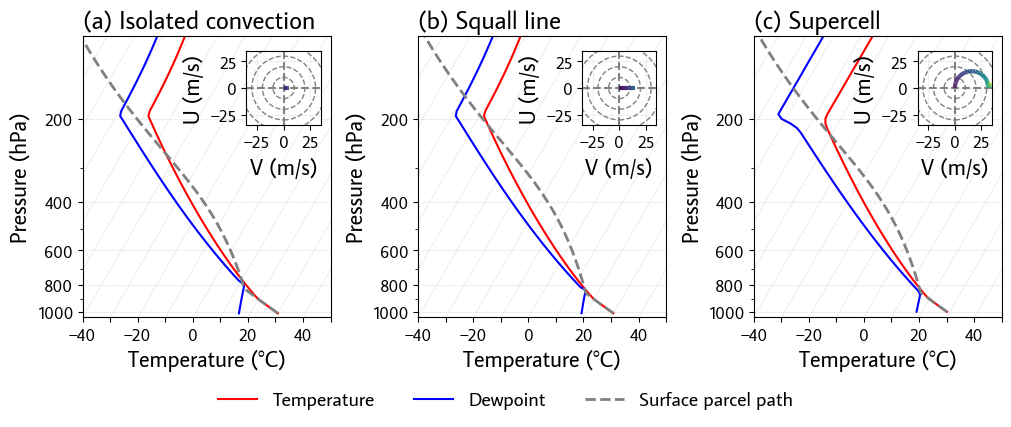

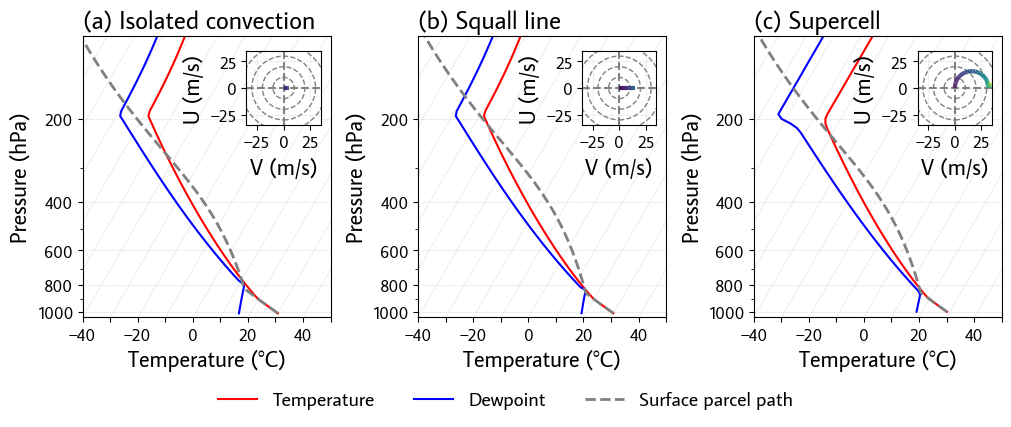

In [10]:
reload(blt)

figure_name = "f01_skewt_logp"
figure_data = {}

storm_skewt_dfs = {
    storm: storm_ds.isel({"time": 0})
    .mean(["x", "y"])[["P", "T", "dewpoint", "UC", "VC"]]
    .to_pandas()
    .reset_index()
    for storm, storm_ds in storm_dss.items()
}

import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10, 5), layout="constrained")
subfigs = fig.subfigures(ncols=3)


def convert_np(arr, ufrom, uto):
    return (arr * units(ufrom)).to(uto).magnitude


legend_artists = []

for storm_ix, (storm, storm_ds) in enumerate(storm_skewt_dfs.items()):

    subfig = subfigs[storm_ix]
    wk_skewt = SkewT(subfig, rotation=30, aspect=1 * 100)
    t_line = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_skewt_temperature",
        wk_skewt.plot,
        storm_ds["P"].values,
        convert_np(storm_ds["T"].values, "K", "degC"),
        "r",
        label="Temperature",
    )
    dp_line = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_skewt_dewpoint",
        wk_skewt.plot,
        storm_ds["P"].values,
        convert_np(storm_ds["dewpoint"].values, "K", "degC"),
        "blue",
        label="Dewpoint",
    )

    # Calculate and plot parcel profile
    wk_parcel_path = mpc.parcel_profile(
        storm_ds["P"].values * units("hPa"),
        storm_ds["T"].values[0] * units("K"),
        storm_ds["dewpoint"].values[0] * units("K"),
    )
    parcel_line = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_surface_parcel_path",
        wk_skewt.plot,
        storm_ds["P"].values,
        wk_parcel_path,
        color="grey",
        linestyle="dashed",
        linewidth=2,
        label="Surface parcel path",
    )
    # subfig.suptitle(f"$U_S$={Us} m/s, $Q_{{v0}}$={qv0} g/kg, shear scale height={zscale} m")

    # Add a hodograph
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    skewt_ax = wk_skewt.ax
    skewt_ax.set_xlabel("Temperature (°C)")
    skewt_ax.set_ylabel("Pressure (hPa)")
    skewt_ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
    for label in skewt_ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    ax_hod = inset_axes(skewt_ax, "30%", "30%", loc=1)
    h = Hodograph(ax_hod, component_range=35.0)
    h.add_grid(increment=10)
    # Only add the winds up to 4 km, so we can see the variation in hodograph color
    this_hodo_ds = storm_ds.loc[storm_ds["z"] <= 8000]
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_hogograph",
        h.plot_colormapped,
        this_hodo_ds["UC"].values,
        this_hodo_ds["VC"].values,
        this_hodo_ds["z"].values,
    )
    ax_hod.set_ylabel("U (m/s)")
    ax_hod.set_xlabel("V (m/s)")

    skewt_ax.set_title(blt.axes_title(storm_ix, blt.STORM_LABELS[storm]))
    # Save the legend artists; this just gets overwritten every time, which is fine
    legend_artists[:] = [t_line[0], dp_line[0], parcel_line[0]]

fig.legend(handles=legend_artists, loc="lower center", ncols=3)

blt.save_figure_data(figure_data, figure_name)
cm.plotting.fig_multisave(fig, figure_name, blt.FIGS_DIR)

## Tracer emission schematic

KeyboardInterrupt: 

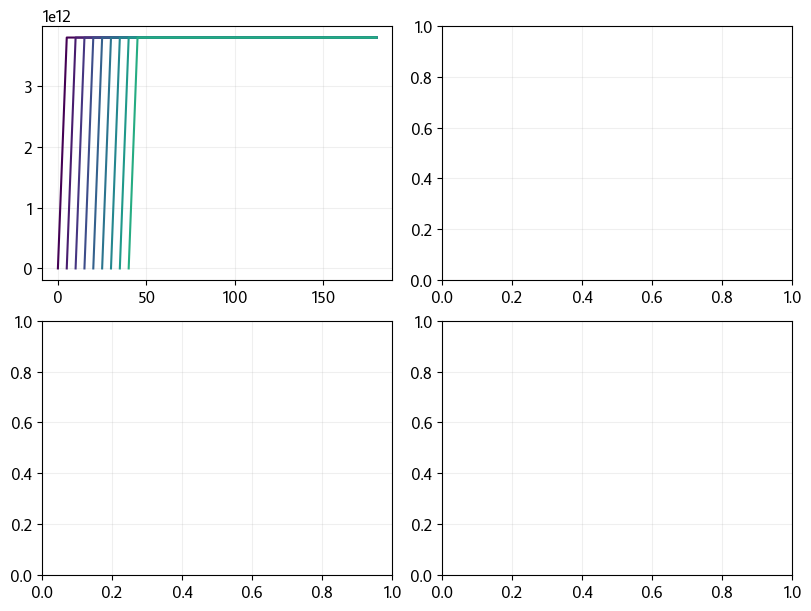

In [11]:
import matplotlib.ticker as ticker

figure_name = "f02_tracer_emission_schematic"
figure_data = {}

# Fixed source
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), layout="constrained")

# Add an axes for a colorbar
# fig.subplots_adjust(right=0.95, hspace=0.2)  # Create space on the right hand side
# cbar_ax = plt.axes([0.98, 0.06, 0.03, 0.88])  # Add a small custom axis

storm_ds = storm_dss["sc_wk"]  # Since it doesn't matter

ax = axs.flatten()[0]
these_tracers = blt.FS_TRACERS[:13]
fs_species_lines = []

for tracer_ix, tracer in enumerate(these_tracers):
    # Want to mask all zero values besides the one right before it becomes not zero
    data = storm_ds["ACC" + tracer].sum(["x", "y"]).compute()
    first_nonzero = (data > 0).argmax("time").values
    data = data.isel({"time": slice(first_nonzero - 1, len(data["time"]))})
    fs_species_lines.append(
        blt.plot_and_save(
            figure_data,
            f"tracer-{tracer}_fs_total_emitted",
            ax.plot,
            data["t_minutes"].values,
            data.values,
            color=mpl.colormaps["viridis"](tracer_ix / len(these_tracers)),
        )[0]
    )

# Always set the vmin and vmax to 0 and 1
fs_cbar = fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=blt.PROGRESSIVE_CMAP + "_r"
    ),
    ax=ax,
    orientation="vertical",
    label="Emission time (minutes)",
)
# fs_cbar = mpl.colorbar.ColorbarBase(
#     ax=ax,
#     cmap=blt.PROGRESSIVE_CMAP + "_r",
#     norm=mpl.colors.Normalize(vmin=0, vmax=1),
#     orientation="vertical",
# )
# Make the tick_values a linear range from 0 to 1 with the number of ticks you want
tick_labels = np.arange(0, 5 * len(these_tracers), 10)
tick_values = (tick_labels / tick_labels[-1])[::-1]
fs_cbar.set_ticks(tick_values)
fs_cbar.set_ticklabels(tick_labels)
# fs_cbar.ax.get_xaxis().labelpad = 10
# fs_cbar.ax.xaxis.set_label_position("top")
# fs_cbar.ax.set_xlabel("Emission time\n(minutes)")

total_line = blt.plot_and_save(
    figure_data,
    f"all_fs_total_emitted",
    ax.plot,
    storm_ds["t_minutes"].values,
    storm_ds["ACCtotal_fs_tracer"].sum(["x", "y"]).values,
    color="darkgrey",
    linestyle="dashed",
    label="Total FS\ntracer emitted",
)[0]

ax.set_xlim([0, 65])
ax.set_title("(a) Fixed-source schematic")
ax.set_ylim([-9572904127692.8, 8e13])
legend = ax.legend(handles=[total_line], loc="upper left")

ax.set_xlabel("Simulation time (minutes)")
ax.set_ylabel("Domain-wide total emitted (#/kg)")

ax_lims = {
    "ic_wk": {"x": [95000, 150000], "y": [90000, 130000]},
    "sl_wk": {"x": [60000, 225000], "y": None},
    "sc_wk": {"x": [75000, 300000], "y": [50000, 200000]},
}

for storm_ix, (storm, storm_ds) in enumerate(storm_dss.items()):
    ax = axs.flatten()[storm_ix + 1]

    for t_ix in range(0, len(storm_ds["time"]), 6):
        tracer_da = storm_ds.isel({"time": t_ix})
        artist = blt.plot_and_save(
            figure_data,
            f"storm-{storm}_tix-{t_ix}_pv_rainfall_rates",
            ax.contourf,
            tracer_da["x"].values,
            tracer_da["y"].values,
            tracer_da["PCPRR"].values,
            levels=blt.RS_TRACER_THRESHOLD_RAIN_RATES,
            cmap=cm.plotting.shifted_blues,
            extend="max",
        )

    these_lims = ax_lims[storm]
    if these_lims["x"]:
        ax.set_xlim(these_lims["x"])
    if these_lims["y"]:
        ax.set_ylim(these_lims["y"])
    cm.plotting.scale_axes_ticks(ax)
    ax.set_xlabel("x (km)")
    ax.set_ylabel("y (km)")
    ax.set_title(blt.axes_title(storm_ix + 1, f"{blt.STORM_LABELS[storm]} rainfall"))
    cbar = fig.colorbar(
        artist, ax=ax, orientation="vertical", label="Rainfall rate (mm/hr)"
    )
    cbar.set_ticklabels(blt.RS_TRACER_THRESHOLDS_MM_HR)

blt.save_figure_data(figure_data, figure_name)
cm.plotting.fig_multisave(fig, figure_name, blt.FIGS_DIR)

## Storm development figures

### Isolated convection

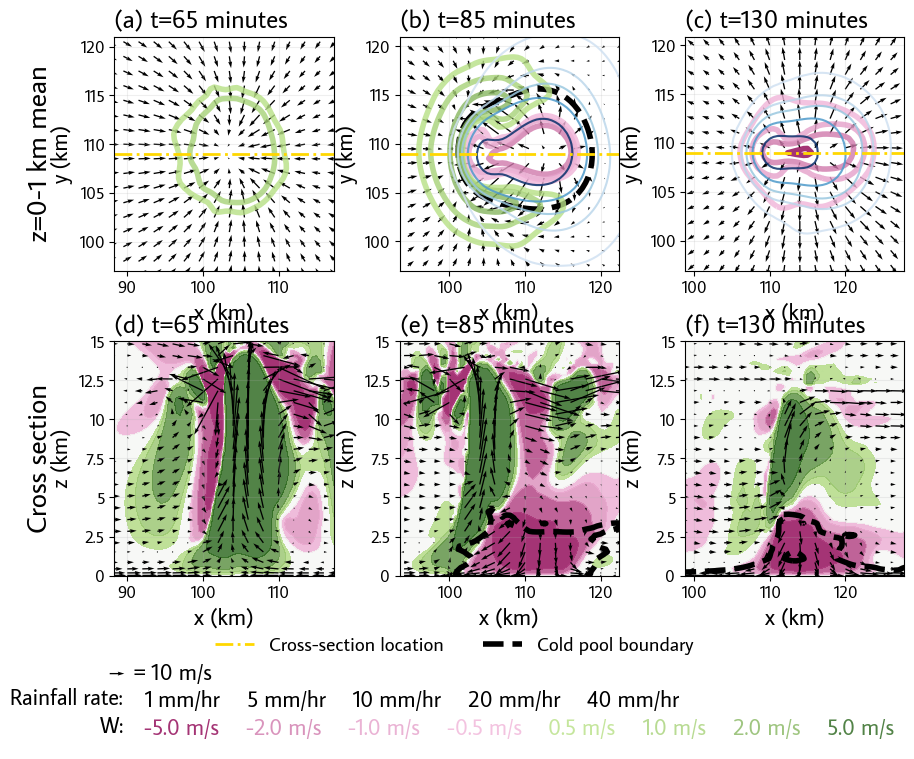

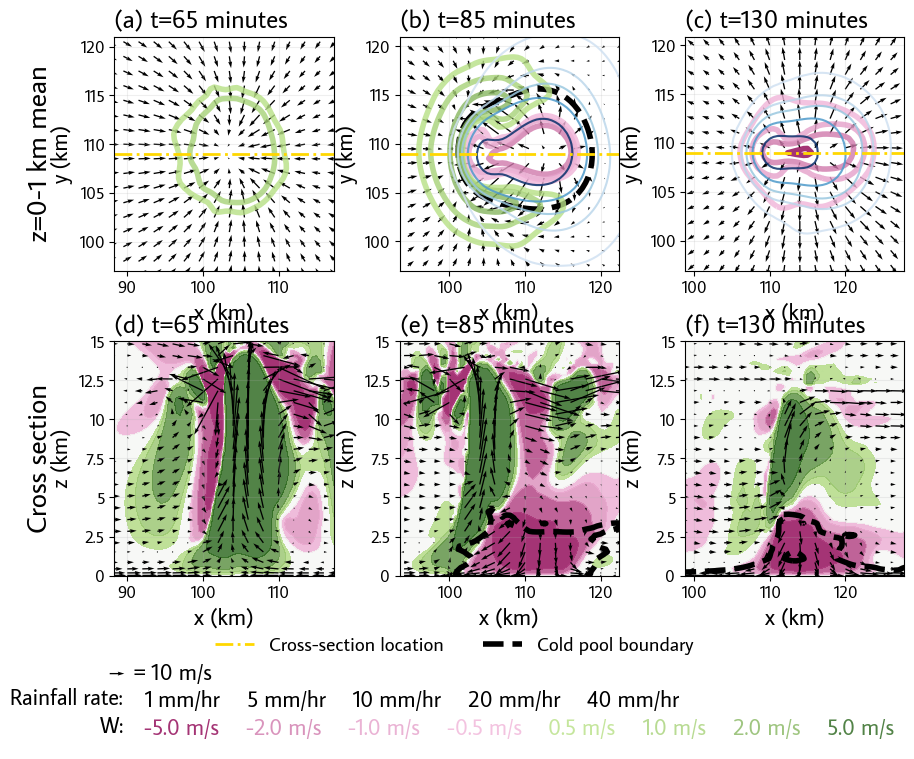

In [ ]:
reload(cm.plotting)
reload(blt)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))

fig.subplots_adjust(bottom=0.18, left=0.16)

# fig.subplots_adjust(left=0.15)
# fig.subplots_adjust(left=0.15, right=0.95)
# cbar_ax = plt.axes([0.96, 0.1, 0.04, 0.79])  # Add a small custom axis

storm_name = "ic_wk"
figure_data = {}
figure_name = f"f03_{storm_name}_storm_development"

development_times_minutes = [65, 85, 130]

x_offsets = [-6000, 0, -9000]
y_offsets = [0, 0, 1000]
cross_section_ys = [109000, 109000, 109000]

quiver_scale = 150
quiver_width = 0.006

updraft_levels = [-5, -2, -1, -0.5, 0.5, 1, 2, 5]
updraft_cmap = cm.plotting.sequential_cmap(
    [
        (0.0, mpl.colormaps["PiYG"](0)),
        (0.45, mpl.colormaps["PiYG"](0.3)),
        (0.5, mpl.colormaps["PiYG"](0.5)),
        (0.55, mpl.colormaps["PiYG"](0.7)),
        (1, mpl.colormaps["PiYG"](0.999)),
    ],
    N=512,
)
updraft_alpha = 0.8
pcprr_alpha = 0.85
legend_fontsize = 16

storm_ds = storm_dss[storm_name]

for t_ix, t_minutes in enumerate(development_times_minutes):
    pv_ax = axs[0, t_ix]
    xc_ax = axs[1, t_ix]

    this_time_storm_ds = storm_ds.sel(
        {"time": blt.minutes_to_simulation_time(t_minutes)}
    )
    # Calculate buoyancy
    this_time_storm_ds["theta_rho"] = this_time_storm_ds["THETA"] * (
        1 + 0.608 * this_time_storm_ds["RV"] - this_time_storm_ds["R_condensate"]
    )
    # And buoyancy
    tr_layer_mean = this_time_storm_ds["theta_rho"].mean(["x", "y"])
    this_time_storm_ds["buoyancy"] = (
        mpconstants.g
        * (this_time_storm_ds["theta_rho"] - tr_layer_mean)
        / tr_layer_mean
    ).pint.dequantify()
    this_time_storm_ds["buoyancy"] = this_time_storm_ds["buoyancy"].where(
        this_time_storm_ds["z"] <= 5000
    )

    # Calculate and set axes limits
    x_position = this_time_storm_ds["storm_position_x"] + x_offsets[t_ix]
    y_position = this_time_storm_ds["storm_position_y"] + y_offsets[t_ix]
    cross_section_y = cross_section_ys[t_ix] or y_position

    xlim = [x_position - 12000, x_position + 17000]
    ylim = [y_position - 12000, y_position + 12000]
    pv_ax.set_xlim(*xlim)
    xc_ax.set_xlim(*xlim)
    pv_ax.set_ylim(*ylim)
    xc_ax.set_ylim([0, 15000])

    quiver_x_spacing = (
        len(this_time_storm_ds["x"].sel({"x": slice(xlim[0], xlim[1] + 1)})["x"].values)
        // 18
    ) + 1
    quiver_y_spacing = (
        len(this_time_storm_ds["y"].sel({"y": slice(ylim[0], ylim[1] + 1)})["y"].values)
        // 18
    ) + 1

    this_01km_ds = (
        this_time_storm_ds.sel({"z": slice(0, 1000)})
        .mean("z")
        .sel(
            {
                "x": slice(xlim[0] - 1000, xlim[1] + 1000),
                "y": slice(ylim[0] - 1000, ylim[1] + 1000),
            }
        )
    )

    # Also will need to subset this to plot the winds
    quiver_x_spacing_01km = 4
    quiver_y_spacing_01km = 4
    this_01km_ds_quiver = this_01km_ds.isel(
        {
            "x": slice(0, len(this_01km_ds["x"]) + 1, quiver_x_spacing),
            "y": slice(0, len(this_01km_ds["y"]) + 1, quiver_y_spacing),
        }
    )

    ######### Plan view #########
    # Cold pool
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_cp",
        pv_ax.contour,
        this_01km_ds["x"].values,
        this_01km_ds["y"].values,
        this_01km_ds["buoyancy"].values,
        levels=[-0.04],
        colors="black",
        linewidths=4,
        # alpha=0.8,
        linestyles="dashed",
    )
    # pv_ax.contour(
    #     *figure_data[data_name],
    #     levels=[-0.04],
    #     colors="black",
    #     linewidths=4,
    #     # alpha=0.8,
    #     linestyles="dashed",
    # )
    cp_line = pv_ax.plot(
        [],
        [],
        color="black",
        linewidth=4,
        linestyle="dashed",
        label="Cold pool boundary",
    )[0]

    # Updraft
    updraft_contours = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_updraft",
        pv_ax.contour,
        this_01km_ds["x"].values,
        this_01km_ds["y"].values,
        this_01km_ds["WC"].values,
        levels=updraft_levels,
        # cmap="PiYG",
        cmap=updraft_cmap,
        alpha=updraft_alpha,
        linewidths=4,
    )

    # Rain
    pcprr_contours = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_rain",
        pv_ax.contour,
        this_time_storm_ds["x"].values,
        this_time_storm_ds["y"].values,
        this_time_storm_ds["PCPRR"].values,
        levels=blt.RS_TRACER_THRESHOLD_RAIN_RATES,
        cmap=cm.plotting.shifted_blues,
        alpha=pcprr_alpha,
        extend="max",
    )

    # Wind
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_wind",
        pv_ax.quiver,
        this_01km_ds_quiver["x"].values,
        this_01km_ds_quiver["y"].values,
        this_01km_ds_quiver["UC"].values,
        this_01km_ds_quiver["VC"].values,
        scale=quiver_scale,
        width=quiver_width,
    )

    # Cross section location
    xc_artist = pv_ax.axhline(
        cross_section_y,
        linestyle="dashdot",
        linewidth=2,
        color="gold",
        label="Cross-section location",
    )

    ######### Panel 4: cross section ##########

    this_xc_ds = this_time_storm_ds.sel({"y": cross_section_y}, method="nearest")

    # Cold pool
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_xc_cp",
        xc_ax.contour,
        this_xc_ds["x"].values,
        this_xc_ds["z"].values,
        this_xc_ds["buoyancy"].values,
        levels=[-0.04],
        colors="black",
        linewidths=4,
        # alpha=0.8,
        linestyles="dashed",
    )

    # Updraft
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_xc_updraft",
        xc_ax.contourf,
        this_xc_ds["x"].values,
        this_xc_ds["z"].values,
        this_xc_ds["WC"].values,
        levels=updraft_levels,
        cmap=updraft_cmap,
        extend="both",
        alpha=updraft_alpha,
    )

    # Wind
    quiver_x_spacing_xc = 4
    # For the cross section, need to take coarser stride in the slice at low levels, so just do this manually
    quiver_z_values_xc = np.concatenate(
        [
            storm_ds.sel({"z": slice(0, 1500)})["z"].values[::5],
            storm_ds.sel({"z": slice(1500, storm_ds["z"].max() + 1)})["z"].values[::3],
        ]
    )
    this_xc_ds_quiver = this_xc_ds.isel(
        {
            "x": slice(0, len(this_xc_ds["x"]) + 1, quiver_x_spacing),
        }
    ).sel({"z": quiver_z_values_xc})

    # Wind
    quiver = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_xc_wind",
        xc_ax.quiver,
        this_xc_ds_quiver["x"].values,
        this_xc_ds_quiver["z"].values,
        this_xc_ds_quiver["UC"].values,
        this_xc_ds_quiver["WC"].values,
        scale=quiver_scale,
        width=quiver_width,
    )

    # Labels
    pv_ax.set_title(blt.axes_title(t_ix, f"t={t_minutes} minutes"))
    xc_ax.set_title(blt.axes_title(3 + t_ix, f"t={t_minutes} minutes"))
    for ax in [pv_ax, xc_ax]:
        ax.set_xlabel("x (km)")
        cm.plotting.scale_axes_ticks(ax)
    pv_ax.set_ylabel("y (km)")
    xc_ax.set_ylabel("z (km)")


plt.legend(
    handles=[xc_artist, cp_line],
    loc="center",
    bbox_to_anchor=(0.5, 0.08),
    bbox_transform=fig.transFigure,
    ncols=2,
)

cm.plotting.add_row_header(
    axs[0, 0],
    "z=0-1 km mean",
    # xycoords="figure fraction",
    # xy=(0.05, 0.76),
)

cm.plotting.add_row_header(
    axs[1, 0],
    "Cross section",
    # xycoords="figure fraction",
    # xy=(0.05, 0.32),
)


quiverkey_speed = 10
axs[0, -1].quiverkey(
    Q=quiver,
    X=0.17,
    Y=0.04,
    U=quiverkey_speed,
    label=f"= {quiverkey_speed} m/s",
    coordinates="figure",
    labelpos="E",
    fontproperties={"size": legend_fontsize},
)

pcprr_legend = cm.plotting.contour_legend(
    pcprr_contours,
    labels=[f"{x} mm/hr" for x in blt.RS_TRACER_THRESHOLDS_MM_HR],
    labelcolor=pcprr_contours.get_facecolors(),
    bbox_to_anchor=(0.17, 0.045),
    bbox_transform=fig.transFigure,
    frameon=False,
    alignment="left",
    columnspacing=1.2,
    fontsize=legend_fontsize,
)
axs[0, 0].annotate(
    "Rainfall rate: ",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(-5, 0),
    textcoords=mpl.text.OffsetFrom(pcprr_legend, (0, 0.4)),
    horizontalalignment="right",
    fontsize=legend_fontsize,
)

updraft_legend = cm.plotting.contour_legend(
    updraft_contours,
    labels=[f"{x} m/s" for x in updraft_contours.levels],
    labelcolor=updraft_contours.get_edgecolors(),
    bbox_to_anchor=(0.17, 0.005),
    bbox_transform=fig.transFigure,
    frameon=False,
    alignment="left",
    columnspacing=1.2,
    fontsize=legend_fontsize,
)
axs[0, 0].annotate(
    "W: ",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(-5, 0),
    textcoords=mpl.text.OffsetFrom(updraft_legend, (0, 0.4)),
    horizontalalignment="right",
    fontsize=legend_fontsize,
)

blt.save_figure_data(figure_data, figure_name)
cm.plotting.fig_multisave(fig, figure_name, blt.FIGS_DIR)

### Squall line

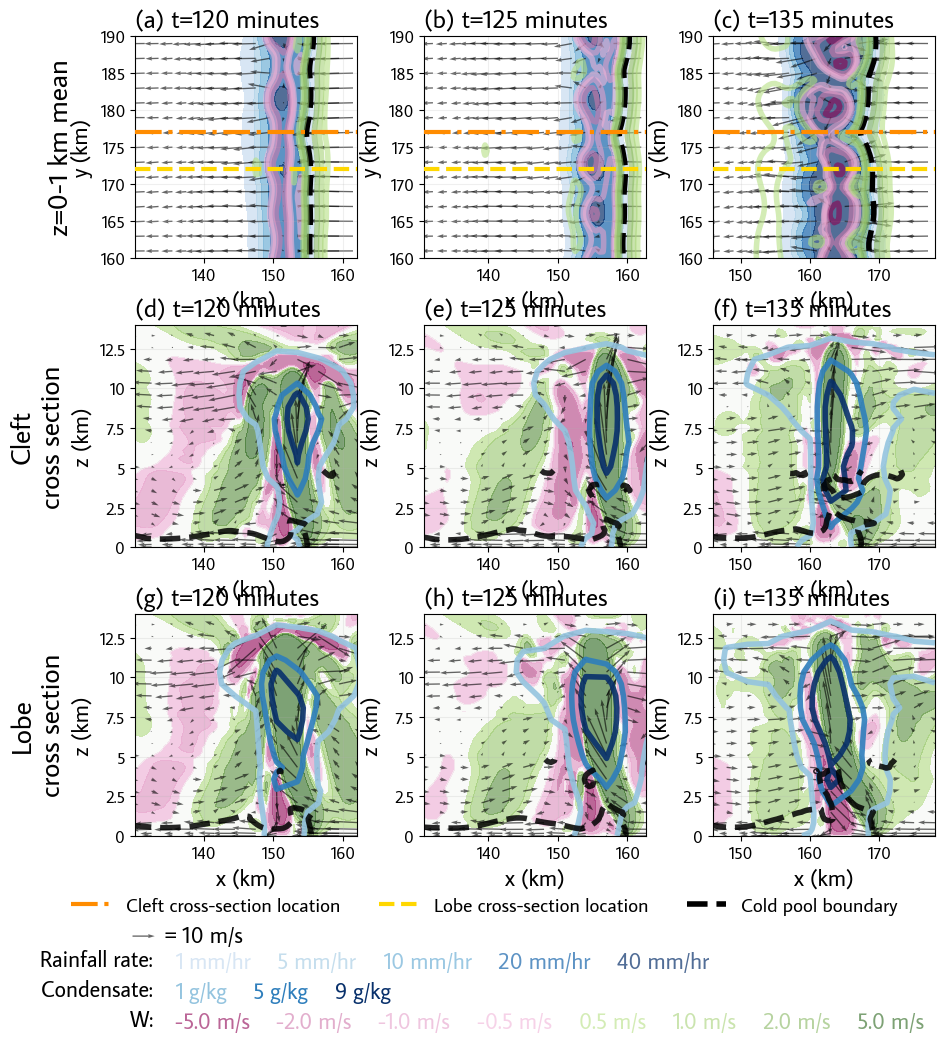

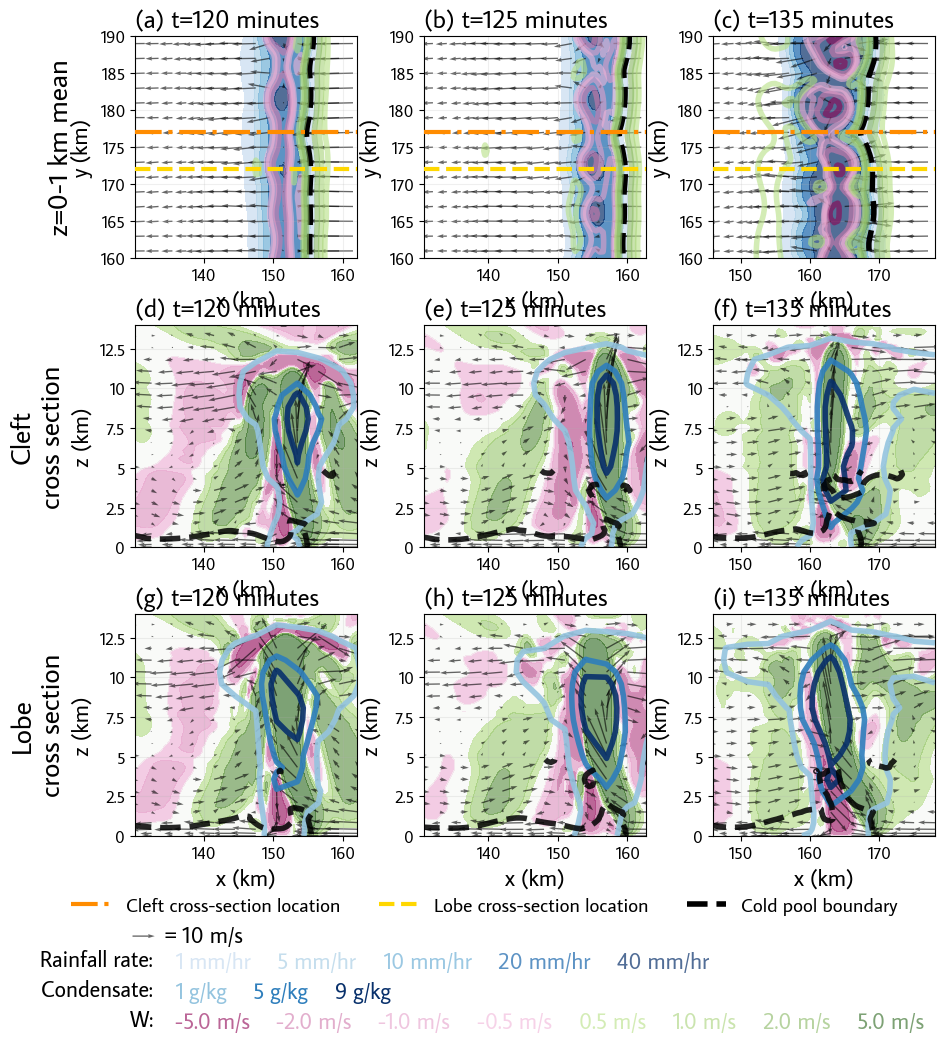

In [ ]:
reload(cm.plotting)

storm_name = "sl_wk"
figure_data = {}
figure_name = f"f04_{storm_name}_storm_development"


development_df = development_dfs[storm_name]
storm_ds = storm_dss[storm_name]

development_df["storm_UC"] = (
    (development_df["storm_centroid_x"].diff() / 300).rolling(3).mean()
)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

fig.subplots_adjust(left=0.15, bottom=0.15)
# fig.subplots_adjust(left=0.15, right=0.95)
# cbar_ax = plt.axes([0.96, 0.1, 0.04, 0.79])  # Add a small custom axis

lobe_y = 172000
cleft_y = 177000

development_times_minutes = [120, 125, 135]
# development_times_minutes = [70, 105, 155]

x_offsets = [-4000, -6000, 2000]
y_offsets = [0, 0, 0]
# cross_section_ys = [109000, 109000, 109000]

quiver_scale = 100
quiver_width = 0.006

updraft_levels = [-5, -2, -1, -0.5, 0.5, 1, 2, 5]
updraft_cmap = cm.plotting.sequential_cmap(
    [
        (0.0, mpl.colormaps["PiYG"](0)),
        (0.45, mpl.colormaps["PiYG"](0.3)),
        (0.5, mpl.colormaps["PiYG"](0.5)),
        (0.55, mpl.colormaps["PiYG"](0.7)),
        (1, mpl.colormaps["PiYG"](0.999)),
    ],
    N=512,
)
updraft_alpha = 0.6
pcprr_alpha = 0.85
legend_fontsize = 16

for t_ix, t_minutes in enumerate(development_times_minutes):

    this_time_storm_ds = storm_ds.sel(
        {"time": blt.minutes_to_simulation_time(t_minutes)}
    )
    # Cut out the upper level cold pool
    this_time_storm_ds["buoyancy"] = this_time_storm_ds["buoyancy"].where(
        this_time_storm_ds["z"] <= 5000
    )

    # Make U storm relative
    this_time_storm_ds["UC"] = (
        this_time_storm_ds["UC"]
        - development_df["storm_UC"]
        .loc[development_df["t_minutes"] == t_minutes]
        .values
    )

    # Calculate and set axes limits
    x_position = this_time_storm_ds["storm_position_x"] + x_offsets[t_ix]
    y_position = this_time_storm_ds["storm_position_y"] + y_offsets[t_ix]

    pv_ax = axs[0, t_ix]

    xlim = [x_position - 20000, x_position + 12000]
    ylim = [160000, 190000]
    pv_ax.set_xlim(*xlim)
    pv_ax.set_ylim(*ylim)
    for ax in axs[1:, t_ix].flatten():
        ax.set_ylim([0, 14000])
        ax.set_xlim(*xlim)

    quiver_x_spacing = (
        len(this_time_storm_ds["x"].sel({"x": slice(xlim[0], xlim[1] + 1)})["x"].values)
        // 18
    ) + 1
    quiver_y_spacing = (
        len(this_time_storm_ds["y"].sel({"y": slice(ylim[0], ylim[1] + 1)})["y"].values)
        // 18
    ) + 1
    quiver_alpha = 0.6

    this_01km_ds = (
        this_time_storm_ds.sel({"z": slice(0, 1000)})
        .mean("z")
        .sel(
            {
                "x": slice(xlim[0] - 1000, xlim[1] + 1000),
                "y": slice(ylim[0] - 1000, ylim[1] + 1000),
            }
        )
    )

    # Also will need to subset this to plot the winds
    quiver_x_spacing_01km = 4
    quiver_y_spacing_01km = 4
    this_01km_ds_quiver = this_01km_ds.isel(
        {
            "x": slice(0, len(this_01km_ds["x"]) + 1, quiver_x_spacing),
            "y": slice(0, len(this_01km_ds["y"]) + 1, quiver_y_spacing),
        }
    )

    ######### Plan view #########
    cp_style_kwargs = {"colors": "black", "linewidths": 4, "linestyles": "dashed"}
    # Cold pool
    pv_ax.contour(
        this_01km_ds["x"],
        this_01km_ds["y"],
        this_01km_ds["buoyancy"],
        levels=[-0.04],
        **cp_style_kwargs,
    )
    # Also make a fake line with the same style for the legend
    cp_line = ax.plot(
        [],
        [],
        label="Cold pool boundary",
        color="black",
        linewidth=4,
        linestyle="dashed",
    )[0]

    # Updraft

    updraft_contours = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_updraft",
        pv_ax.contour,
        this_01km_ds["x"],
        this_01km_ds["y"],
        this_01km_ds["WC"],
        levels=updraft_levels,
        cmap=updraft_cmap,
        alpha=updraft_alpha,
        linewidths=4,
    )

    # Rain
    pcprr_contours = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_rain",
        pv_ax.contourf,
        this_time_storm_ds["x"],
        this_time_storm_ds["y"],
        this_time_storm_ds["PCPRR"],
        levels=blt.RS_TRACER_THRESHOLD_RAIN_RATES,
        cmap=cm.plotting.shifted_blues,
        alpha=0.7,
        extend="max",
    )

    # Wind
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_wind",
        pv_ax.quiver,
        this_01km_ds_quiver["x"],
        this_01km_ds_quiver["y"],
        this_01km_ds_quiver["UC"],
        this_01km_ds_quiver["VC"],
        scale=quiver_scale,
        width=quiver_width,
        alpha=quiver_alpha,
    )

    # Cross section lines
    lobe_line = pv_ax.axhline(
        lobe_y,
        linewidth=3,
        color="gold",
        linestyle="dashed",
        zorder=999,
        label="Lobe cross-section location",
    )
    cleft_line = pv_ax.axhline(
        cleft_y,
        linewidth=3,
        color="darkorange",
        linestyle="dashdot",
        zorder=999,
        label="Cleft cross-section location",
    )

    ########## Cross sections ##########

    for xc_y_ix, xc_y in enumerate([cleft_y, lobe_y]):

        cl_label = ["cleft", "lobe"][xc_y_ix]

        this_xc_ds = this_time_storm_ds.sel({"y": xc_y}, method="nearest").sel(
            {"x": slice(xlim[0] - 1000, xlim[1] + 1000), "z": slice(0, 15000)}
        )
        xc_ax = axs[xc_y_ix + 1, t_ix]

        # Cold pool
        blt.plot_and_save(
            figure_data,
            f"storm-{storm}_t-{t_minutes}_xc-{cl_label}_cp",
            xc_ax.contour,
            this_xc_ds["x"],
            this_xc_ds["z"],
            this_xc_ds["buoyancy"],
            levels=[-0.04],
            colors="black",
            # colors=[mpl.colormaps["Greys"](0.7)],
            linewidths=4,
            alpha=0.85,
            linestyles="dashed",
            # dashes=(5, 5),
            zorder=999,
        )

        # Updraft
        blt.plot_and_save(
            figure_data,
            f"storm-{storm}_t-{t_minutes}_xc-{cl_label}_updraft",
            xc_ax.contourf,
            this_xc_ds["x"],
            this_xc_ds["z"],
            this_xc_ds["WC"],
            levels=updraft_levels,
            cmap=updraft_cmap,
            alpha=updraft_alpha,
            extend="both",
        )

        # Wind
        quiver_x_spacing_xc = 4
        # For the cross section, need to take coarser stride in the slice at low levels, so just do this manually
        quiver_z_values_xc = np.concatenate(
            [
                storm_ds.sel({"z": slice(0, 1500)})["z"].values[::5],
                storm_ds.sel({"z": slice(1500, this_xc_ds["z"].max() + 1)})["z"].values[
                    ::3
                ],
            ]
        )
        this_xc_ds_quiver = this_xc_ds.isel(
            {
                "x": slice(0, len(this_xc_ds["x"]) + 1, quiver_x_spacing + 2),
            }
        ).sel({"z": quiver_z_values_xc})

        # Wind
        quiver = blt.plot_and_save(
            figure_data,
            f"storm-{storm}_t-{t_minutes}_xc-{cl_label}_wind",
            xc_ax.quiver,
            this_xc_ds_quiver["x"],
            this_xc_ds_quiver["z"],
            this_xc_ds_quiver["UC"],
            this_xc_ds_quiver["WC"],
            scale=quiver_scale,
            width=quiver_width,
            alpha=quiver_alpha,
        )

        # Condensate
        condensate_contours = blt.plot_and_save(
            figure_data,
            f"storm-{storm}_t-{t_minutes}_xc-{cl_label}_condensate",
            xc_ax.contour,
            this_xc_ds_quiver["x"],
            this_xc_ds_quiver["z"],
            this_xc_ds_quiver["R_condensate"],
            cmap=cm.plotting.shifted_colormap("Blues", [0.4, 1]),
            levels=np.arange(0.001, 0.0091, 0.004),
            alpha=0.9,
            linewidths=4,
            # linestyles="dashdot",
        )

    # Labels
    pv_ax.set_title(blt.axes_title(t_ix, f"t={t_minutes} minutes"))
    axs[1, t_ix].set_title(blt.axes_title(3 + t_ix, f"t={t_minutes} minutes"))
    axs[2, t_ix].set_title(blt.axes_title(6 + t_ix, f"t={t_minutes} minutes"))
    pv_ax.set_ylabel("y (km)")
    for ax in axs[:, t_ix]:
        ax.set_xlabel("x (km)")
        cm.plotting.scale_axes_ticks(ax)
    for ax in axs[1:, t_ix]:
        ax.set_ylabel("z (km)")

cm.plotting.add_row_header(
    axs[0, 0],
    "z=0-1 km mean",
    # xycoords="figure fraction",
    # xy=(0.05, 0.85),
)

cm.plotting.add_row_header(axs[1, 0], "Cleft\ncross section", pad=20)

cm.plotting.add_row_header(axs[2, 0], "Lobe\ncross section", pad=20)

plt.legend(
    handles=[cleft_line, lobe_line, cp_line],
    loc="center",
    bbox_to_anchor=(0.5, 0.08),
    bbox_transform=fig.transFigure,
    # frameon=True,
    # facecolor="whitesmoke",
    # framealpha=0.7,
    ncols=3,
)

quiverkey_speed = 10
axs[-1, 0].quiverkey(
    Q=quiver,
    X=0.17,
    Y=0.05,
    U=quiverkey_speed,
    label=f"= {quiverkey_speed} m/s",
    coordinates="figure",
    labelpos="E",
    fontproperties={"size": legend_fontsize},
)

pcprr_legend = cm.plotting.contour_legend(
    pcprr_contours,
    labels=[f"{x} mm/hr" for x in blt.RS_TRACER_THRESHOLDS_MM_HR],
    labelcolor=pcprr_contours.get_facecolors(),
    bbox_to_anchor=(0.17, 0.055),
    bbox_transform=fig.transFigure,
    frameon=False,
    alignment="left",
    columnspacing=1.2,
    fontsize=legend_fontsize,
)
axs[-1, 0].annotate(
    "Rainfall rate: ",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(-5, 0),
    textcoords=mpl.text.OffsetFrom(pcprr_legend, (0, 0.4)),
    horizontalalignment="right",
    fontsize=legend_fontsize,
)

updraft_legend = cm.plotting.contour_legend(
    updraft_contours,
    labels=[f"{x} m/s" for x in updraft_contours.levels],
    labelcolor=updraft_contours.get_edgecolors(),
    bbox_to_anchor=(0.17, -0.005),
    bbox_transform=fig.transFigure,
    frameon=False,
    alignment="left",
    columnspacing=1.2,
    fontsize=legend_fontsize,
)

axs[-1, 0].annotate(
    "W: ",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(-5, 0),
    textcoords=mpl.text.OffsetFrom(updraft_legend, (0, 0.4)),
    horizontalalignment="right",
    fontsize=legend_fontsize,
)


condensate_legend = cm.plotting.contour_legend(
    condensate_contours,
    labels=[f"{x*1000:.0f} g/kg" for x in condensate_contours.levels],
    labelcolor=[(c[0], c[1], c[2], 1) for c in condensate_contours.get_edgecolors()],
    bbox_to_anchor=(0.17, 0.025),
    bbox_transform=fig.transFigure,
    frameon=False,
    alignment="left",
    columnspacing=1.2,
    fontsize=legend_fontsize,
)
axs[-1, 0].annotate(
    "Condensate: ",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(-5, 0),
    textcoords=mpl.text.OffsetFrom(condensate_legend, (0, 0.4)),
    horizontalalignment="right",
    fontsize=legend_fontsize,
)

blt.save_figure_data(figure_data, figure_name)
cm.plotting.fig_multisave(fig, f"{storm_name}_storm_development", blt.FIGS_DIR)

### Supercell

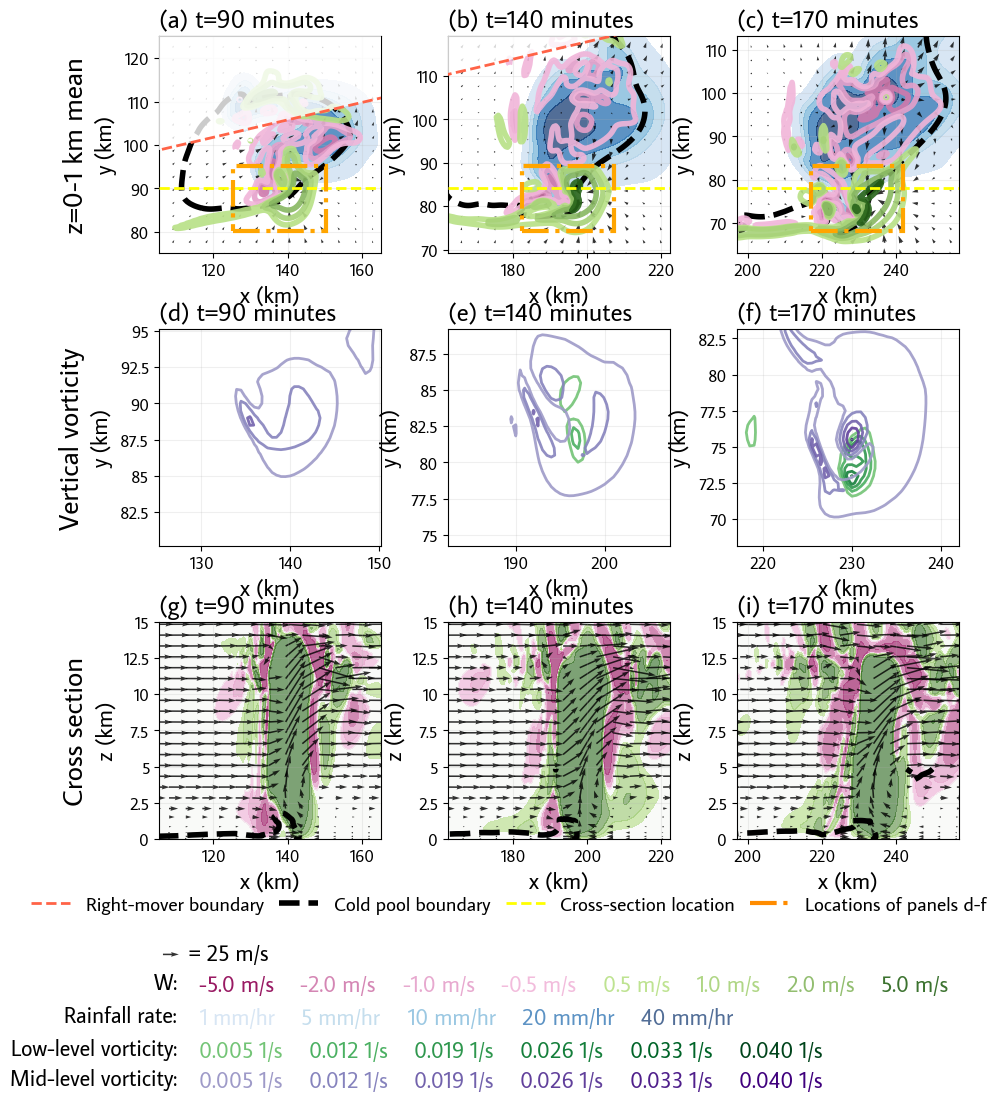

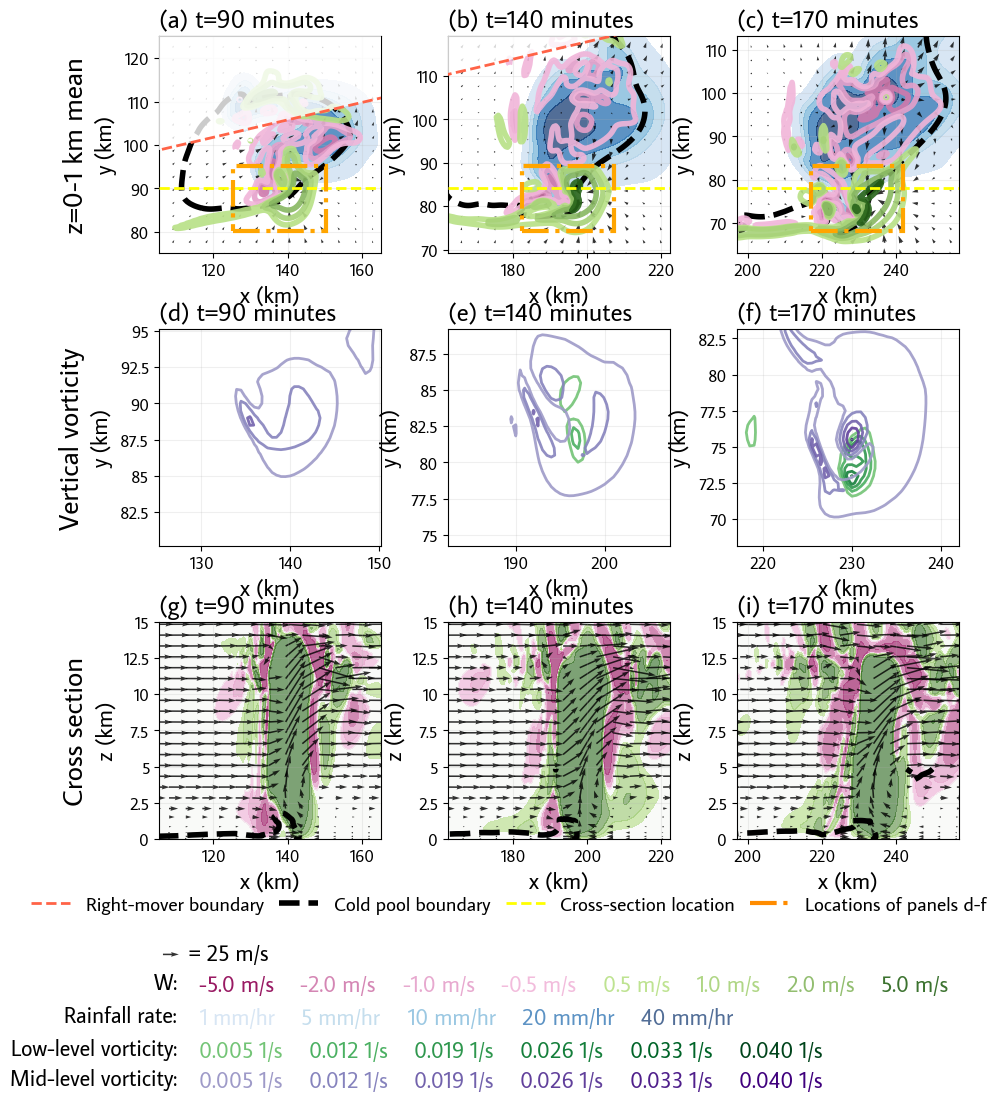

In [ ]:
reload(cm.plotting)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 11))

fig.subplots_adjust(left=0.15, bottom=0.22, hspace=0.35)
# fig.subplots_adjust(left=0.15, right=0.95)
# cbar_ax = plt.axes([0.96, 0.1, 0.04, 0.79])  # Add a small custom axis

storm_name = "sc_wk"
figure_name = f"f05_{storm_name}_storm_development"
figure_data = {}

storm_ds = storm_dss[storm_name]
development_df = development_dfs[storm_name]

# Calculate vertical vorticity
storm_ds["vertical_vorticity"] = storm_ds["VC"].differentiate("x") - storm_ds[
    "UC"
].differentiate("y")

development_times_minutes = [90, 140, 170]

x_offsets = [0, 0, 0]
y_offsets = [0, 0, 0]
cross_section_ys = [None, None, None]

quiver_scale = 350
quiver_width = 0.007

updraft_levels = [-5, -2, -1, -0.5, 0.5, 1, 2, 5]
updraft_cmap = cm.plotting.sequential_cmap(
    [
        (0.0, mpl.colormaps["PiYG"](0)),
        (0.45, mpl.colormaps["PiYG"](0.3)),
        (0.5, mpl.colormaps["PiYG"](0.5)),
        (0.55, mpl.colormaps["PiYG"](0.7)),
        (1, mpl.colormaps["PiYG"](0.999)),
    ],
    N=512,
)
updraft_alpha = 0.6
pcprr_alpha = 0.85
legend_fontsize = 16
lm_boundary_edgecolor = "tomato"


def lm_polygon():
    return plt.Polygon(
        [
            (storm_ds["x"].min(), blt.sc_wk_right_mover_boundary(storm_ds["x"].min())),
            (storm_ds["x"].min(), storm_ds["y"].max()),
            (storm_ds["x"].max(), storm_ds["y"].max()),
            (storm_ds["x"].max(), blt.sc_wk_right_mover_boundary(storm_ds["x"].max())),
        ],
        closed=True,
        facecolor=(1, 1, 1, 0.8),
        edgecolor=lm_boundary_edgecolor,
        linestyle="dashed",
        linewidth=2,
        zorder=999,
    )


for ax in axs[:2, :].flatten():
    ax.add_patch(lm_polygon())
    lm_boundary_line = ax.plot(
        [],
        [],
        color=lm_boundary_edgecolor,
        linestyle="dashed",
        linewidth=2,
        label="Right-mover boundary",
    )[0]

for t_ix, t_minutes in enumerate(development_times_minutes):

    this_time_storm_ds = storm_ds.sel(
        {"time": blt.minutes_to_simulation_time(t_minutes)}
    )
    # Filter to low-level cold pool
    this_time_storm_ds["buoyancy"] = this_time_storm_ds["buoyancy"].where(
        this_time_storm_ds["z"] <= 5000
    )

    # Calculate and set axes limits
    x_position = this_time_storm_ds["storm_position_x"] + x_offsets[t_ix]
    y_position = this_time_storm_ds["storm_position_y"] + y_offsets[t_ix]
    cross_section_y = cross_section_ys[t_ix] or y_position

    xlim = [x_position - 35000, x_position + 25000]
    ylim = [y_position - 15000, y_position + 35000]
    for ax in axs[:, t_ix]:
        ax.set_xlim(*xlim)
    for ax in axs[:2, t_ix]:
        ax.set_ylim(*ylim)
    axs[2, t_ix].set_ylim([0, 15000])

    quiver_x_spacing = (
        len(this_time_storm_ds["x"].sel({"x": slice(xlim[0], xlim[1] + 1)})["x"].values)
        // 18
    ) + 1
    quiver_y_spacing = (
        len(this_time_storm_ds["y"].sel({"y": slice(ylim[0], ylim[1] + 1)})["y"].values)
        // 18
    ) + 1

    this_01km_ds = (
        this_time_storm_ds.sel({"z": slice(0, 1000)})
        .mean("z")
        .sel(
            {
                "x": slice(xlim[0] - 1000, xlim[1] + 1000),
                "y": slice(ylim[0] - 1000, ylim[1] + 1000),
            }
        )
    )

    # Also will need to subset this to plot the winds
    quiver_alpha = 0.8

    this_01km_ds_quiver = this_01km_ds.isel(
        {
            "x": slice(0, len(this_01km_ds["x"]) + 1, quiver_x_spacing + 2),
            "y": slice(0, len(this_01km_ds["y"]) + 1, quiver_y_spacing),
        }
    )

    ######### Plan view #########

    # Cold pool
    pv_ax = axs[0, t_ix]
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_cp",
        pv_ax.contour,
        this_01km_ds["x"],
        this_01km_ds["y"],
        this_01km_ds["buoyancy"],
        levels=[-0.04],
        colors="black",
        linewidths=4,
        # alpha=0.8,
        linestyles="dashed",
    )
    cp_line = pv_ax.plot(
        [],
        [],
        color="black",
        linewidth=4,
        linestyle="dashed",
        label="Cold pool boundary",
    )[0]

    # Updraft
    updraft_contours = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_updraft",
        pv_ax.contour,
        this_01km_ds["x"],
        this_01km_ds["y"],
        this_01km_ds["WC"],
        levels=updraft_levels,
        # cmap="PiYG",
        cmap=updraft_cmap,
        alpha=0.9,
        linewidths=4,
    )

    # Rain
    pcprr_contours = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_rain",
        pv_ax.contourf,
        this_time_storm_ds["x"],
        this_time_storm_ds["y"],
        this_time_storm_ds["PCPRR"],
        levels=blt.RS_TRACER_THRESHOLD_RAIN_RATES,
        cmap=cm.plotting.shifted_blues,
        alpha=0.7,
        extend="max",
    )

    # Wind
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_pv_wind",
        pv_ax.quiver,
        this_01km_ds_quiver["x"],
        this_01km_ds_quiver["y"],
        this_01km_ds_quiver["UC"],
        this_01km_ds_quiver["VC"],
        scale=quiver_scale,
        width=quiver_width,
        alpha=quiver_alpha,
    )

    # Add a line indicating the cross section
    xc_line = pv_ax.axhline(
        cross_section_y,
        linewidth=2,
        color="yellow",
        linestyle="dashed",
        zorder=999,
        label="Cross-section location",
    )

    ########## Vorticity ##########

    # Vertical vorticity
    # Low level
    vorticity_ax = axs[1, t_ix]
    low_vorticity_contours = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_vorticity_low",
        vorticity_ax.contour,
        this_01km_ds["x"],
        this_01km_ds["y"],
        this_01km_ds["vertical_vorticity"],
        cmap=cm.plotting.shifted_colormap("Greens", [0.5, 1]),
        levels=np.arange(0.005, 0.041, 0.007),
        alpha=0.9,
        linewidths=2,
    )
    # Midlevel
    this_5km_ds = this_time_storm_ds.sel({"z": 5000}, method="nearest")
    mid_vorticity_contours = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_vorticity_mid",
        vorticity_ax.contour,
        this_5km_ds["x"],
        this_5km_ds["y"],
        this_5km_ds["vertical_vorticity"],
        cmap=cm.plotting.shifted_colormap("Purples", [0.5, 1]),
        levels=np.arange(0.005, 0.041, 0.007),
        alpha=0.9,
        # linestyles="dashed",
        linewidths=2,
    )

    # Set the limits and add squares on panels 1 and 2
    vorticity_ax.set_xlim(xlim[0] + 20000, xlim[1] - 15000)
    vorticity_ax.set_ylim(ylim[0] + 5000, ylim[1] - 30000)

    def rectangle_patch():
        return mpl.patches.Rectangle(
            xy=(vorticity_ax.get_xlim()[0], vorticity_ax.get_ylim()[0]),
            width=vorticity_ax.get_xlim()[1] - vorticity_ax.get_xlim()[0],
            height=vorticity_ax.get_ylim()[1] - vorticity_ax.get_ylim()[0],
            linestyle="dashdot",
            linewidth=3,
            edgecolor="orange",
            facecolor=(0, 0, 0, 0),
            zorder=999,
        )

    pv_ax.add_patch(rectangle_patch())
    vorticity_area_line = pv_ax.plot(
        [],
        [],
        linestyle="dashdot",
        color="darkorange",
        linewidth=3,
        label="Locations of panels d-f",
    )[0]

    ########## Cross section ##########

    this_xc_ds = this_time_storm_ds.sel({"y": cross_section_y}, method="nearest")
    xc_ax = axs[2, t_ix]

    # Cold pool
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_xc_cp",
        xc_ax.contour,
        this_xc_ds["x"],
        this_xc_ds["z"],
        this_xc_ds["buoyancy"],
        levels=[-0.04],
        colors="black",
        linewidths=4,
        # alpha=0.8,
        linestyles="dashed",
    )

    # Updraft
    blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_xc_updraft",
        xc_ax.contourf,
        this_xc_ds["x"],
        this_xc_ds["z"],
        this_xc_ds["WC"],
        levels=updraft_levels,
        # cmap="PiYG",
        cmap=updraft_cmap,
        alpha=updraft_alpha,
        extend="both",
    )

    # Wind
    # For the cross section, need to take coarser stride in the slice at low levels, so just do this manually
    quiver_z_values_xc = np.concatenate(
        [
            storm_ds.sel({"z": slice(0, 1500)})["z"].values[::5],
            storm_ds.sel({"z": slice(1500, storm_ds["z"].max() + 1)})["z"].values[::3],
        ]
    )
    this_xc_ds_quiver = this_xc_ds.isel(
        {
            "x": slice(0, len(this_xc_ds["x"]) + 1, quiver_x_spacing + 2),
        }
    ).sel({"z": quiver_z_values_xc})

    # Wind
    quiver = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_t-{t_minutes}_xc_wind",
        xc_ax.quiver,
        this_xc_ds_quiver["x"],
        this_xc_ds_quiver["z"],
        this_xc_ds_quiver["UC"],
        this_xc_ds_quiver["WC"],
        scale=quiver_scale,
        width=quiver_width,
        alpha=quiver_alpha,
    )

    # Labels
    pv_ax.set_title(blt.axes_title(t_ix, f"t={t_minutes} minutes"))
    vorticity_ax.set_title(blt.axes_title(3 + t_ix, f"t={t_minutes} minutes"))
    xc_ax.set_title(blt.axes_title(6 + t_ix, f"t={t_minutes} minutes"))

    for ax in axs[:, t_ix]:
        ax.set_xlabel("x (km)")
        cm.plotting.scale_axes_ticks(ax)
    pv_ax.set_ylabel("y (km)")
    vorticity_ax.set_ylabel("y (km)")
    xc_ax.set_ylabel("z (km)")


# plt.tight_layout()

cm.plotting.add_row_header(axs[0, 0], "z=0-1 km mean", pad=10)

cm.plotting.add_row_header(axs[1, 0], "Vertical vorticity", pad=10)

cm.plotting.add_row_header(axs[2, 0], "Cross section", pad=10)

plt.legend(
    handles=[lm_boundary_line, cp_line, xc_line, vorticity_area_line],
    loc="center",
    bbox_to_anchor=(0.5, 0.16),
    bbox_transform=fig.transFigure,
    ncols=4,
    columnspacing=0.8,
)

quiverkey_speed = 25
axs[-1, 0].quiverkey(
    Q=quiver,
    X=0.17,
    Y=0.115,
    U=quiverkey_speed,
    label=f"= {quiverkey_speed} m/s",
    coordinates="figure",
    labelpos="E",
    fontproperties={"size": legend_fontsize},
)

column_spacing = 1.2

updraft_legend = cm.plotting.contour_legend(
    updraft_contours,
    labels=[f"{x} m/s" for x in updraft_contours.levels],
    labelcolor=updraft_contours.get_edgecolors(),
    bbox_to_anchor=(0.17, 0.115),
    bbox_transform=fig.transFigure,
    frameon=False,
    alignment="left",
    columnspacing=column_spacing,
    fontsize=legend_fontsize,
)
# axs[0, 0].annotate(
#     "W: ", xy=(0.17, 0.088), xycoords=fig.transFigure, horizontalalignment="right", fontsize=legend_fontsize
# )
axs[-1, 0].annotate(
    "W: ",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(-5, 0),
    textcoords=mpl.text.OffsetFrom(updraft_legend, (0, 0.4)),
    horizontalalignment="right",
    fontsize=legend_fontsize,
)
pcprr_legend = cm.plotting.contour_legend(
    pcprr_contours,
    labels=[f"{x} mm/hr" for x in blt.RS_TRACER_THRESHOLDS_MM_HR],
    labelcolor=pcprr_contours.get_facecolors(),
    bbox_to_anchor=(0.17, 0.085),
    bbox_transform=fig.transFigure,
    frameon=False,
    alignment="left",
    columnspacing=column_spacing,
    fontsize=legend_fontsize,
)
# axs[0, 0].annotate(
#     "Rainfall rate: ",
#     xy=(0.17, 0.0575),
#     xycoords=fig.transFigure,
#     horizontalalignment="right",
#     fontsize=legend_fontsize,
# )
axs[-1, 0].annotate(
    "Rainfall rate: ",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(-5, 0),
    textcoords=mpl.text.OffsetFrom(pcprr_legend, (0, 0.4)),
    horizontalalignment="right",
    fontsize=legend_fontsize,
)

low_vorticity_legend = cm.plotting.contour_legend(
    low_vorticity_contours,
    labels=[f"{x:.3f} 1/s" for x in low_vorticity_contours.levels],
    labelcolor=[(c[0], c[1], c[2], 1) for c in low_vorticity_contours.get_edgecolors()],
    bbox_to_anchor=(0.17, 0.055),
    bbox_transform=fig.transFigure,
    frameon=False,
    alignment="left",
    columnspacing=column_spacing,
    fontsize=legend_fontsize,
)
# axs[0, 0].annotate(
#     "Low-level vorticity: ",
#     xy=(0.17, 0.03),
#     xycoords=fig.transFigure,
#     horizontalalignment="right",
#     fontsize=legend_fontsize,
# )
axs[-1, 0].annotate(
    "Low-level vorticity: ",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(-5, 0),
    textcoords=mpl.text.OffsetFrom(low_vorticity_legend, (0, 0.4)),
    horizontalalignment="right",
    fontsize=legend_fontsize,
)


mid_vorticity_legend = cm.plotting.contour_legend(
    mid_vorticity_contours,
    labels=[f"{x:.3f} 1/s" for x in mid_vorticity_contours.levels],
    labelcolor=[(c[0], c[1], c[2], 1) for c in mid_vorticity_contours.get_edgecolors()],
    bbox_to_anchor=(0.17, 0.028),
    bbox_transform=fig.transFigure,
    frameon=False,
    alignment="left",
    columnspacing=column_spacing,
    fontsize=legend_fontsize,
)
# axs[0, 0].annotate(
#     "Mid-level vorticity: ",
#     xy=(0.17, 0.003),
#     xycoords=fig.transFigure,
#     horizontalalignment="right",
#     fontsize=legend_fontsize,
# )
axs[-1, 0].annotate(
    "Mid-level vorticity: ",
    xy=(0, 0),
    xycoords="figure fraction",
    xytext=(-5, 0),
    textcoords=mpl.text.OffsetFrom(mid_vorticity_legend, (0, 0.4)),
    horizontalalignment="right",
    fontsize=legend_fontsize,
)


blt.save_figure_data(figure_data, figure_name)
cm.plotting.fig_multisave(
    fig, f"{storm_name}_storm_development", blt.FIGS_DIR, extensions=[".pdf", ".png"]
)

## Storm development stats

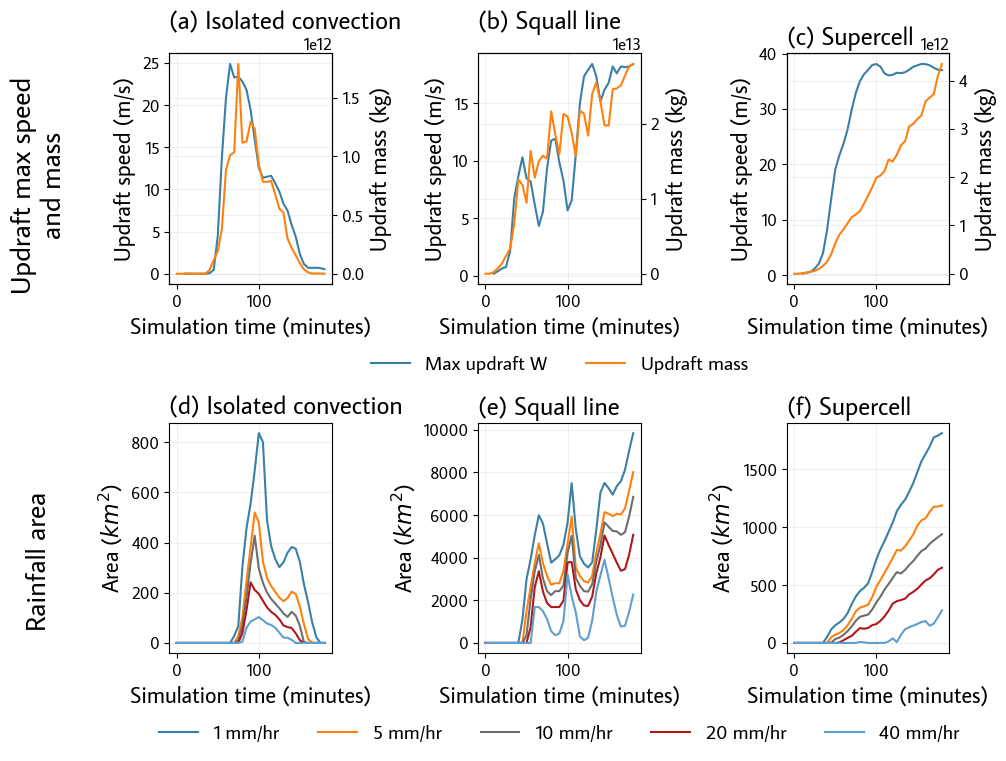

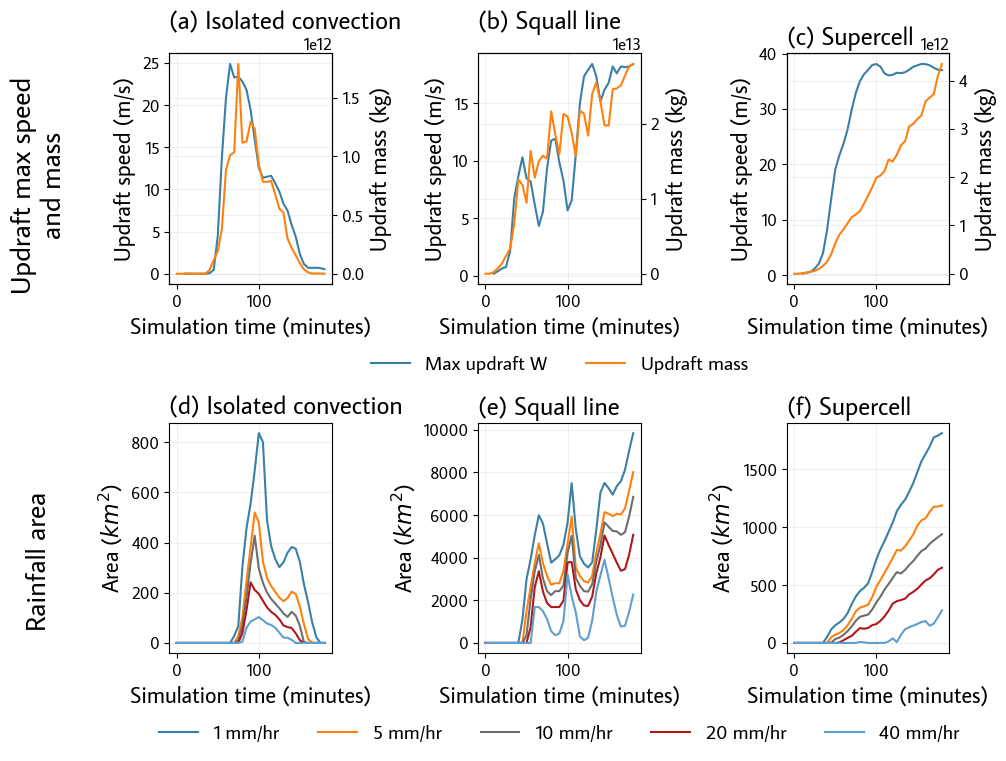

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
fig.subplots_adjust(hspace=0.6, left=0.17, wspace=0.9, bottom=0.2)

storm_dev_stats = {}

updraft_axs = []

figure_name = f"f09_storm_development_stats"
figure_data = {}


def ss_max_w(axs, ax_title_start_ix=0):
    updraft_axs = []
    for storm_ix, (storm, label) in enumerate(blt.STORM_LABELS.items()):

        ax = axs[storm_ix]
        development_df = development_dfs[storm]

        # Updraft
        blt.plot_and_save(
            figure_data,
            f"storm-{storm}_max_updraft",
            ax.plot,
            development_df["t_minutes"],
            development_df["max_updraft"],
            label="Max updraft W",
            color=cm.plotting.get_nth_color(0),
        )
        updraft_twin_ax = ax.twinx()
        blt.plot_and_save(
            figure_data,
            f"storm-{storm}_updraft_mass",
            updraft_twin_ax.plot,
            development_df["t_minutes"],
            development_df["updraft_mass"],
            label="Updraft mass",
            color=cm.plotting.get_nth_color(1),
        )
        updraft_axs.append(updraft_twin_ax)
        # Add an empty line to make the legend right
        ax.plot([], [], color=cm.plotting.get_nth_color(1), label="Updraft mass")
        ax.set_xlabel("Simulation time (minutes)")
        ax.set_ylabel("Updraft speed (m/s)")
        ax.set_title(
            blt.axes_title(ax_title_start_ix + storm_ix, blt.STORM_LABELS[storm])
        )
        updraft_twin_ax.set_ylabel("Updraft mass (kg)")
    axs[1].legend(
        loc="center",
        bbox_to_anchor=(0.5, -0.35),
        ncol=2,
        # bbox_transform=ax.transFigure,
    )
    # cm.plotting.clean_legend(axs[0], loc="upper left")


def ss_rain(axs, ax_title_start_ix=0):
    for storm_ix, (storm, label) in enumerate(blt.STORM_LABELS.items()):
        ax = axs[storm_ix]
        development_df = development_dfs[storm]
        # Rain
        for threshold_ix in range(len(blt.RS_TRACER_THRESHOLD_RAIN_RATES)):
            blt.plot_and_save(
                figure_data,
                f"storm-{storm}_rain-{int(blt.RS_TRACER_THRESHOLDS_MM_HR[threshold_ix])}mmhr_area",
                ax.plot,
                development_df["t_minutes"],
                development_df[f"rain_threshold{threshold_ix}"]
                * 500**2
                / 1e6,  # To make it square kilometers
                label=f"{blt.RS_TRACER_THRESHOLDS_MM_HR[threshold_ix]} mm/hr",
            )

        ax.set_xlabel("Simulation time (minutes)")
        ax.set_ylabel(r"Area ($km^{2}$)")
        ax.set_title(
            blt.axes_title(ax_title_start_ix + storm_ix, blt.STORM_LABELS[storm])
        )
    axs.flatten()[1].legend(
        # cm.plotting.clean_legend(
        # axs.flatten()[1],
        loc="center",
        bbox_to_anchor=(0.5, -0.35),
        # bbox_transform=fig.transFigure,
        ncol=5,
    )


ss_max_w(axs[0])
ss_rain(axs[1], ax_title_start_ix=3)

# plt.tight_layout()
# fig.subplots_adjust()

cm.plotting.add_row_header(
    axs[0, 0],
    "Updraft max speed\nand mass",
    xycoords="figure fraction",
    xy=(0.05, 0.72),
)
cm.plotting.add_row_header(
    axs[1, 0],
    "Rainfall area",
    xycoords="figure fraction",
    xy=(0.05, 0.25),
)

blt.save_figure_data(figure_data, figure_name)
cm.plotting.fig_multisave(fig, figure_name, blt.FIGS_DIR)

## IC surface temperature by rain intensity

time
1991-04-26 21:00:00         NaN
1991-04-26 21:05:00         NaN
1991-04-26 21:10:00         NaN
1991-04-26 21:15:00         NaN
1991-04-26 21:20:00         NaN
1991-04-26 21:25:00         NaN
1991-04-26 21:30:00         NaN
1991-04-26 21:35:00         NaN
1991-04-26 21:40:00         NaN
1991-04-26 21:45:00         NaN
1991-04-26 21:50:00         NaN
1991-04-26 21:55:00         NaN
1991-04-26 22:00:00         NaN
1991-04-26 22:05:00         NaN
1991-04-26 22:10:00         NaN
1991-04-26 22:15:00         NaN
1991-04-26 22:20:00    2.052301
1991-04-26 22:25:00    2.878647
1991-04-26 22:30:00    2.441388
1991-04-26 22:35:00    1.529696
1991-04-26 22:40:00    1.155558
1991-04-26 22:45:00    0.634817
1991-04-26 22:50:00    0.307042
1991-04-26 22:55:00    0.427146
1991-04-26 23:00:00    0.509852
1991-04-26 23:05:00    0.457120
1991-04-26 23:10:00    0.047351
1991-04-26 23:15:00    0.057696
1991-04-26 23:20:00    0.099051
1991-04-26 23:25:00         NaN
1991-04-26 23:30:00         NaN
199

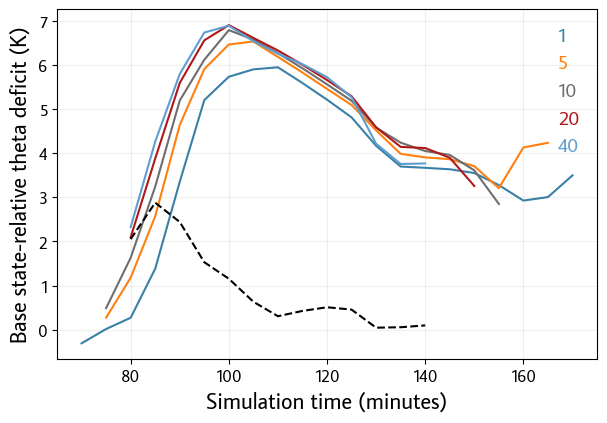

In [ ]:
fig, ax = plt.subplots()

figure_name = "storm-ic_wk_surface_theta_by_rain_intensity"
figure_data = {}

storm_ds = storm_dss["ic_wk"].copy()
mean_deficits = {}
for rs_threshold_ix, rs_threshold in enumerate(blt.RS_TRACER_THRESHOLD_RAIN_RATES):
    mean_deficits[rs_threshold] = (
        storm_ds["theta_deficit"]
        .sel({"z": slice(0, 500)})
        .weighted(storm_ds["PCPRR"] >= rs_threshold)
        .mean(["x", "y", "z"])
    )
    blt.plot_and_save(
        figure_data,
        f"storm-ic_wk_rain-{int(blt.RS_TRACER_THRESHOLDS_MM_HR[rs_threshold_ix])}mmhr_theta_deficit",
        ax.plot,
        storm_ds["t_minutes"].values,
        mean_deficits[rs_threshold].values,
        color=cm.plotting.get_nth_color(rs_threshold_ix),
        label=blt.RS_TRACER_THRESHOLDS_MM_HR[rs_threshold_ix],
    )

diff = (
    mean_deficits[blt.RS_TRACER_THRESHOLD_RAIN_RATES[-1]]
    - mean_deficits[blt.RS_TRACER_THRESHOLD_RAIN_RATES[0]]
)
blt.plot_and_save(
    figure_data,
    f"storm-ic_wk_1mmhr_40mmhr_difference_theta_deficit",
    ax.plot,
    storm_ds["t_minutes"].values,
    diff.values,
    color="black",
    linestyle="dashed",
)

display(diff.to_pandas())

cm.plotting.clean_legend(ax)
ax.set_xlabel("Simulation time (minutes)")
ax.set_ylabel("Base state-relative theta deficit (K)")
blt.save_figure_data(figure_data, figure_name)

## Tracer entrainment

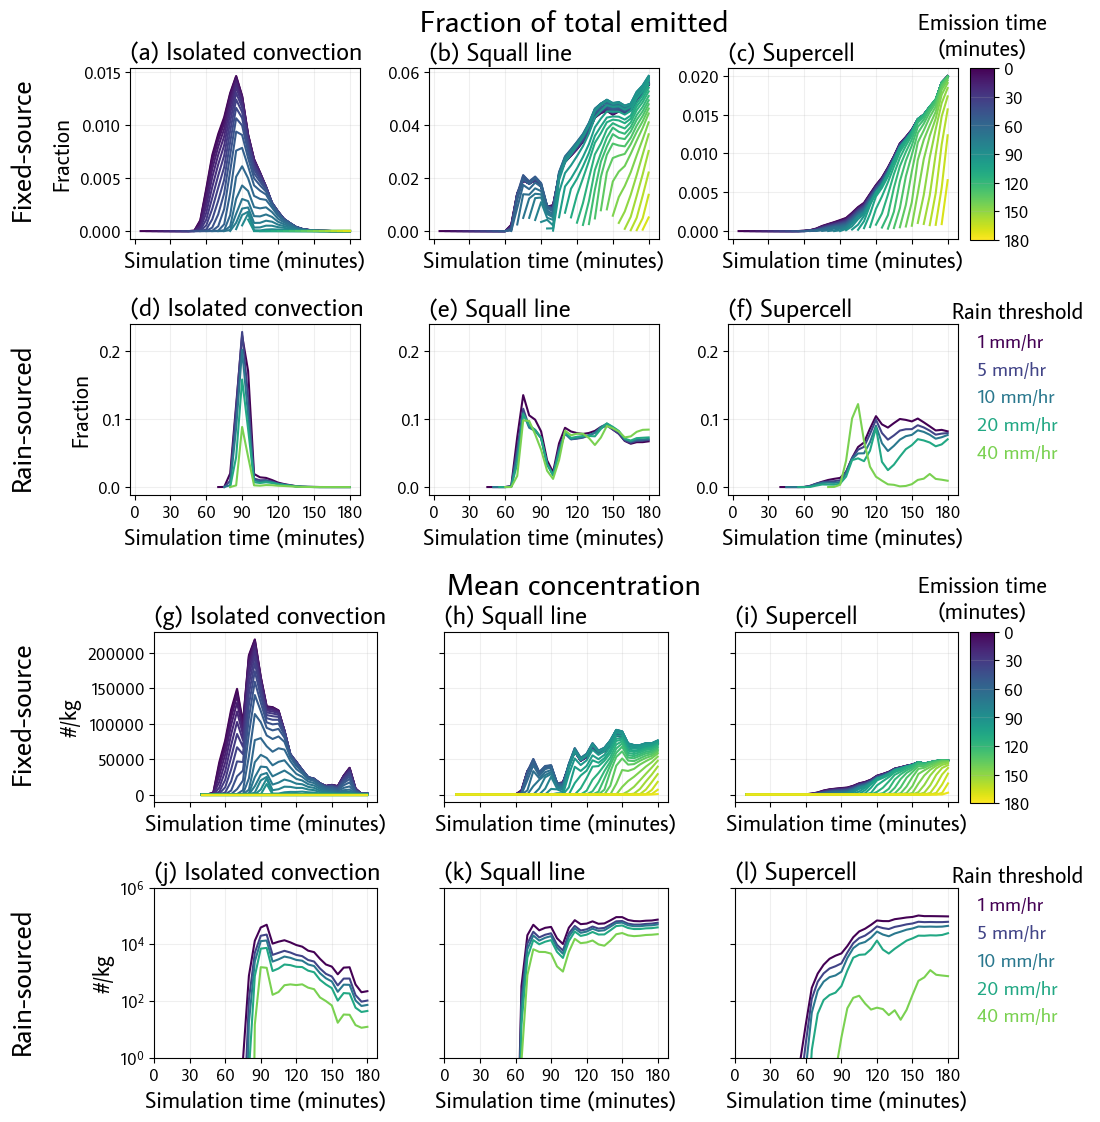

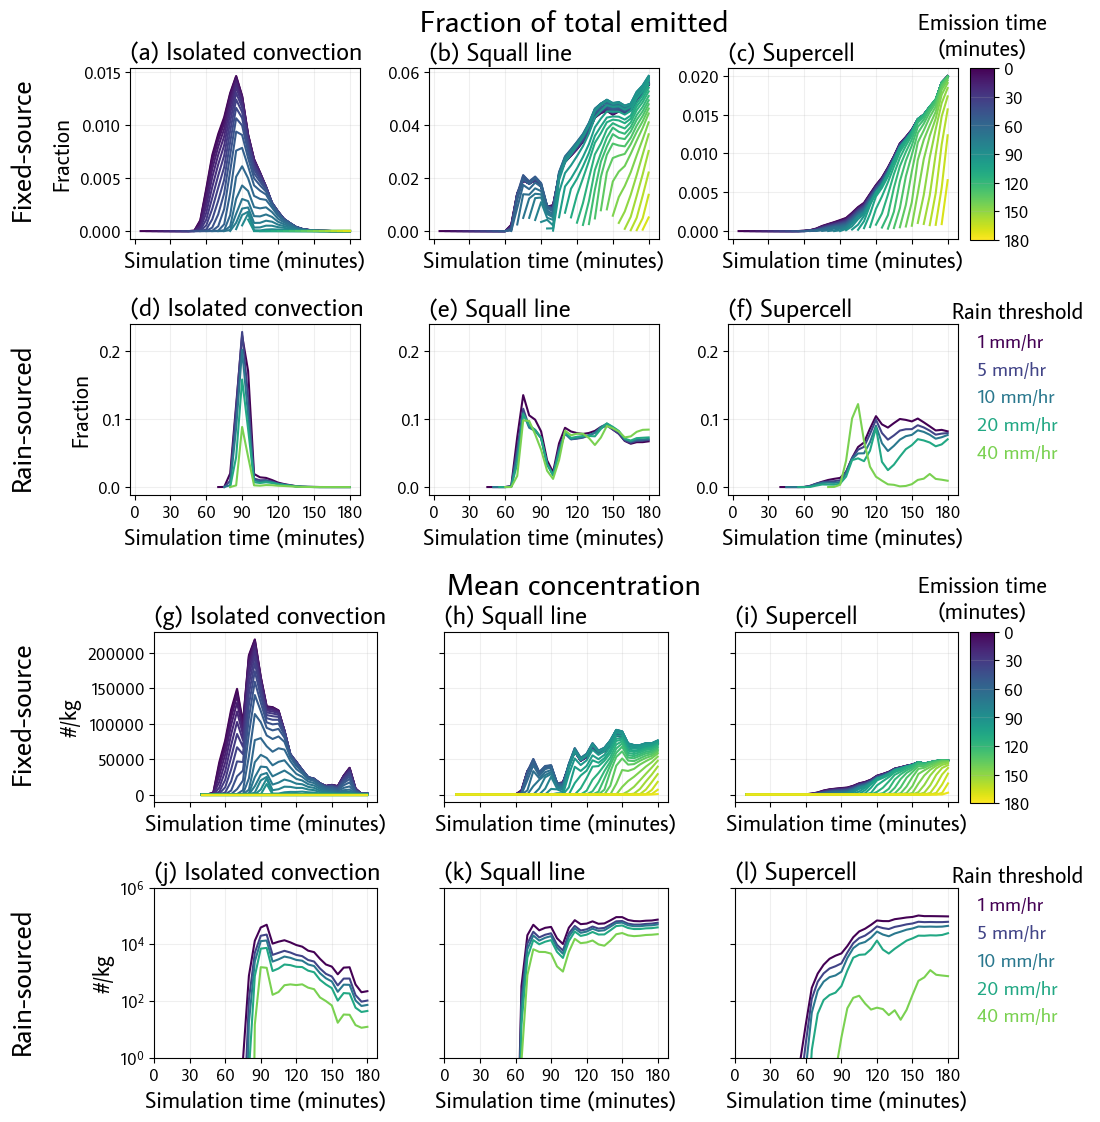

In [ ]:
reload(cm.plotting)

figure_name = "f06_tracer_entrainment"
figure_data = {}

fig = plt.figure(figsize=(12, 11))
outer_subfigs = fig.subfigures(nrows=2, hspace=0.05)

########## Fractions ##########
axs = outer_subfigs[0].subplots(nrows=2, ncols=3, sharex=True)

# Space it better
outer_subfigs[0].subplots_adjust(left=0.13, hspace=0.5, top=0.87, right=0.82)


for tracer_type_ix, tracer_type in enumerate(["Fixed-source", "Rain-sourced"]):
    for storm_ix, (storm, this_tracer_ds) in enumerate(tracer_totals_dss.items()):

        ax = axs[tracer_type_ix, storm_ix]
        if tracer_type_ix == 0:
            for ix, tracer in enumerate(blt.FS_TRACERS):
                blt.plot_and_save(
                    figure_data,
                    f"storm-{storm}_tracer-{tracer}_frac_entrained_of_emitted",
                    ax.plot,
                    this_tracer_ds["t_minutes"],
                    this_tracer_ds[tracer + "_nc"]
                    / this_tracer_ds["ACC" + tracer + "_nc"],
                    color=mpl.colormaps[blt.PROGRESSIVE_CMAP](ix / len(blt.FS_TRACERS)),
                )
        else:
            # Rain-sourced
            for ix, tracer in enumerate(blt.RS_TRACERS):
                blt.plot_and_save(
                    figure_data,
                    f"storm-{storm}_tracer-{tracer}_frac_entrained_of_emitted",
                    ax.plot,
                    this_tracer_ds["t_minutes"],
                    (
                        this_tracer_ds[tracer + "_nc"]
                        / this_tracer_ds["ACC" + tracer + "_nc"]
                    ).values,
                    color=mpl.colormaps[blt.PROGRESSIVE_CMAP](ix / len(blt.RS_TRACERS)),
                    label=str(blt.RS_TRACER_THRESHOLDS_MM_HR[ix]) + " mm/hr",
                )

        ax.set_title(
            blt.axes_title(storm_ix + tracer_type_ix * 3, blt.STORM_LABELS[storm])
        )
        if storm_ix == 0:
            ax.set_ylabel("Fraction")
        blt.label_x_axis(ax)

    # Add the row headers
    cm.plotting.add_row_header(
        axs[tracer_type_ix, 0],
        "Fixed-source" if tracer_type_ix == 0 else "Rain-sourced",
        xycoords="subfigure fraction",
        xy=(0.05, 0.72 - 0.5 * tracer_type_ix),
    )

    # Make the mean row share the y axis
    # x is already shared between all 6 in this subfigure so don't mess with it here
    cm.plotting.share_axes(axs[1], x=False, y=True)

outer_subfigs[0].suptitle("Fraction of total emitted", fontsize=22)


########## Means ##########
axs = outer_subfigs[1].subplots(nrows=2, ncols=3, sharex=True, sharey="row")

# Space it better
outer_subfigs[1].subplots_adjust(left=0.15, hspace=0.5, top=0.87, right=0.82)

for tracer_type_ix, tracer_type in enumerate(["Fixed-source", "Rain-sourced"]):
    for storm_ix, (storm, this_tracer_ds) in enumerate(tracer_totals_dss.items()):
        ax = axs[tracer_type_ix, storm_ix]
        if tracer_type_ix == 0:
            for ix, tracer in enumerate(sorted(blt.FS_TRACERS)):
                blt.plot_and_save(
                    figure_data,
                    f"storm-{storm}_tracer-{tracer}_nc",
                    ax.plot,
                    this_tracer_ds["t_minutes"],
                    this_tracer_ds[tracer + "_nc"] / this_tracer_ds["air_mass"],
                    color=mpl.colormaps[blt.PROGRESSIVE_CMAP](ix / len(blt.FS_TRACERS)),
                )
        else:
            # Rain-sourced
            for ix, tracer in enumerate(blt.RS_TRACERS):
                blt.plot_and_save(
                    figure_data,
                    f"storm-{storm}_tracer-{tracer}_nc",
                    ax.plot,
                    this_tracer_ds["t_minutes"],
                    (
                        this_tracer_ds[tracer + "_nc"] / this_tracer_ds["air_mass"]
                    ).values,
                    color=mpl.colormaps[blt.PROGRESSIVE_CMAP](ix / len(blt.RS_TRACERS)),
                    label=str(blt.RS_TRACER_THRESHOLDS_MM_HR[ix]) + " mm/hr",
                )

        # Make these log scale
        if tracer_type_ix == 1:
            ax.set_yscale("log")
            ax.set_ylim([1e0, 1e6])
        ax.set_title(
            blt.axes_title(6 + storm_ix + tracer_type_ix * 3, blt.STORM_LABELS[storm])
        )
        if storm_ix == 0:
            ax.set_ylabel("#/kg")
        blt.label_x_axis(ax)

    # Add the row headers
    cm.plotting.add_row_header(
        axs[tracer_type_ix, 0],
        "Fixed-source" if tracer_type_ix == 0 else "Rain-sourced",
        xycoords="subfigure fraction",
        xy=(0.05, 0.72 - 0.5 * tracer_type_ix),
    )


outer_subfigs[1].suptitle("Mean concentration", fontsize=22)

# Add the colorbars
for subfig in outer_subfigs:
    # First do the fixed-source
    fs_cbar_ax = subfig.add_axes(
        [0.83, 0.55, 0.02, 0.32]
    )  # Left, bottom, width, height

    # Always set the vmin and vmax to 0 and 1
    fs_cbar = mpl.colorbar.ColorbarBase(
        ax=fs_cbar_ax,
        cmap=blt.PROGRESSIVE_CMAP + "_r",
        norm=mpl.colors.Normalize(vmin=0, vmax=1),
        orientation="vertical",
    )
    # Make the tick_values a linear range from 0 to 1 with the number of ticks you want
    tick_labels = np.arange(0, 181, 30)
    tick_values = (tick_labels / 180)[::-1]
    fs_cbar.set_ticks(tick_values)
    fs_cbar.set_ticklabels(tick_labels)
    fs_cbar_ax.xaxis.set_label_position("top")
    fs_cbar_ax.set_xlabel("Emission time\n(minutes)")
    fs_cbar_ax.get_xaxis().labelpad = 10

    # Now rain-sourced
    # Just make a legend here rather than a colorbar since it's only six values
    cm.plotting.clean_legend(
        subfig.axes[3],
        bbox_transform=subfig.transSubfigure,
        title="Rain threshold",
        bbox_to_anchor=[0.800, 0.468],  # x, y, width, height
        fontsize=14,
        title_fontsize=16,
        loc="upper left",
    )

blt.save_figure_data(figure_data, figure_name)
cm.plotting.fig_multisave(
    fig,
    figure_name,
    blt.FIGS_DIR,
    no_title_version=False,
)

## RS entrainment factors

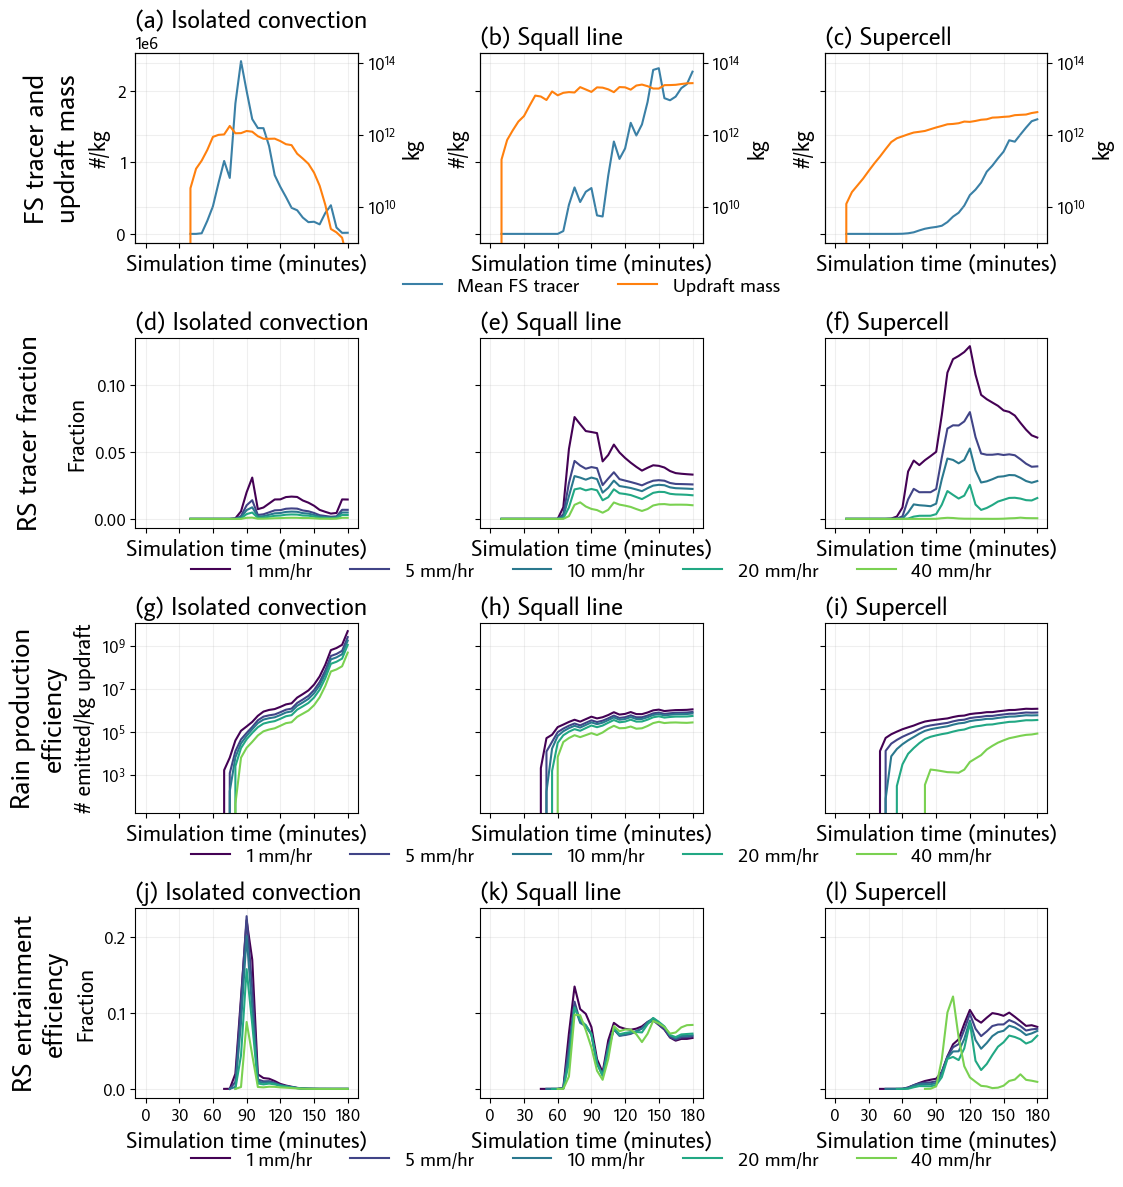

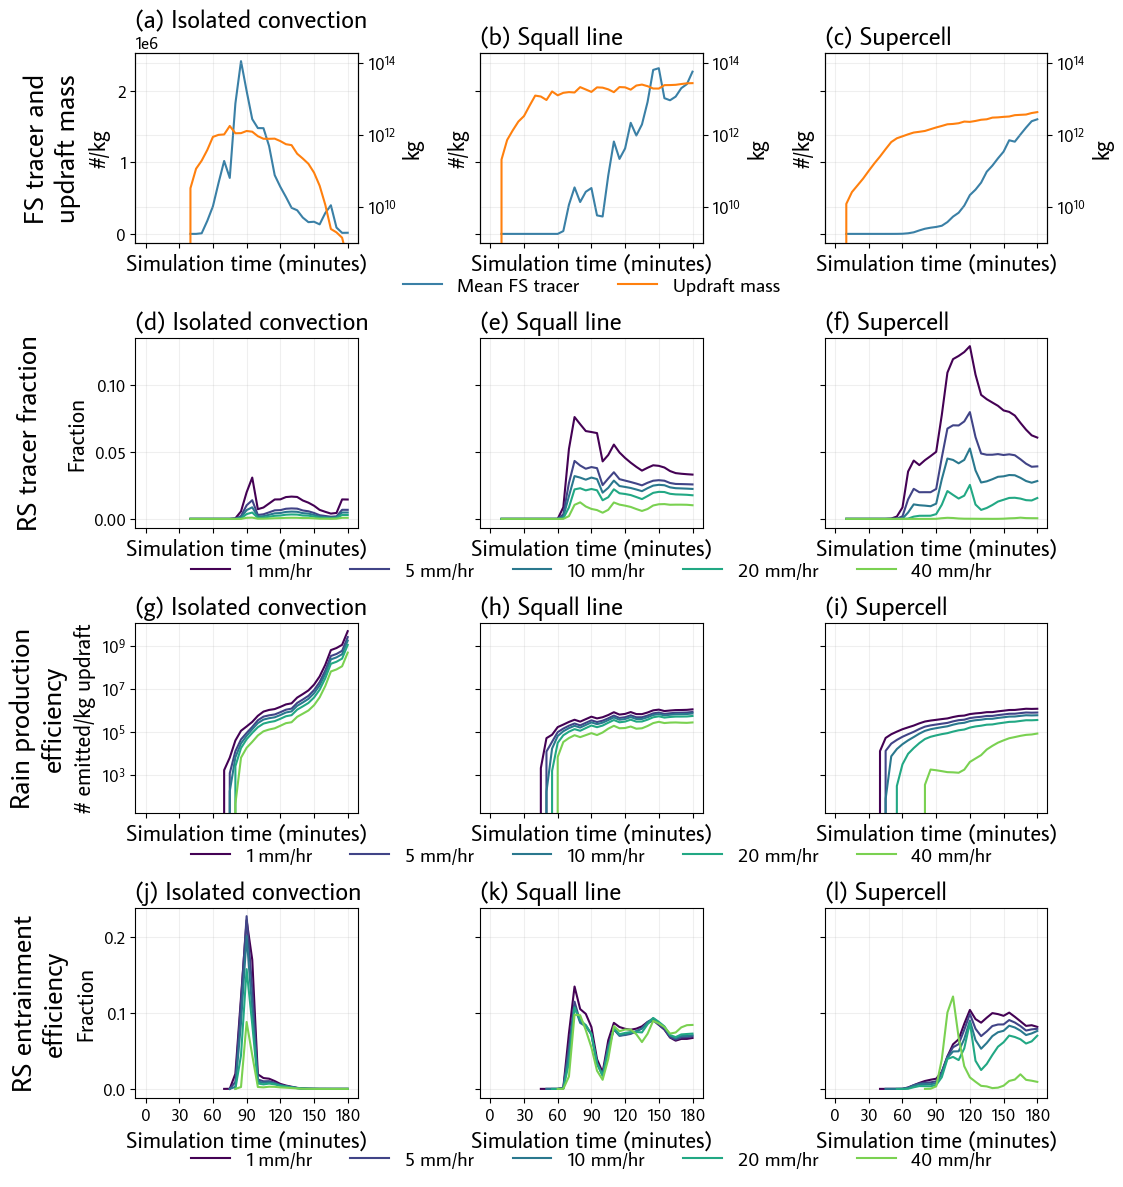

In [ ]:
reload(cm.plotting)

from matplotlib.transforms import Bbox

figure_data = {}
figure_name = "f08_rs_entrainment_factors"

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 11), sharex=True, sharey="row")
fig.subplots_adjust(wspace=0.55, left=0.19, hspace=0.5, bottom=0)

headers = []

bbox_to_anchor = (0.5, -0.23)


# Make functions for each row of this figure so that we can easily break them out into their own figures
def rs_factors_fs_entrainment(axs, ax_title_start_ix=0):
    updraft_axs = []
    for storm_ix, (storm, this_tracer_totals_ds) in enumerate(
        tracer_totals_dss.items()
    ):

        ax = axs[storm_ix]

        blt.plot_and_save(
            figure_data,
            f"storm-{storm}_fs_entrainment",
            ax.plot,
            this_tracer_totals_ds["t_minutes"],
            this_tracer_totals_ds["total_fs_tracer_nc"]
            / this_tracer_totals_ds["air_mass"],
            label="Mean FS tracer",
            color=cm.plotting.get_nth_color(0),
        )
        # Add an empty line to make the legend right
        ax.plot([], [], color=cm.plotting.get_nth_color(1), label="Updraft mass")
        updraft_ax = ax.twinx()
        updraft_axs.append(updraft_ax)
        blt.plot_and_save(
            figure_data,
            f"storm-{storm}_updraft_mass",
            updraft_ax.plot,
            this_tracer_totals_ds["t_minutes"],
            this_tracer_totals_ds["air_mass"],
            color=cm.plotting.get_nth_color(1),
        )
        updraft_ax.set_yscale("log")

        ax.set_title(
            blt.axes_title(ax_title_start_ix + storm_ix, blt.STORM_LABELS[storm])
        )

        ax.set_ylabel("#/kg")
        blt.label_x_axis(ax)
        updraft_ax.set_ylabel("kg")

    # Share the y axes of the updraft axes
    cm.plotting.share_axes(updraft_axs, x=False, y=True)
    # Set the ylim of them
    for ax in updraft_axs:
        ax.set_ylim([1e9, 2e14])

    axs[1].legend(loc="center", bbox_to_anchor=bbox_to_anchor, ncol=2)
    # cm.plotting.clean_legend(axs[0], loc="upper left")


def rs_factors_rs_fraction(axs, ax_title_start_ix=0):
    for storm_ix, (storm, this_tracer_totals_ds) in enumerate(
        tracer_totals_dss.items()
    ):
        # Second row: RS tracer fraction
        ax = axs[storm_ix]
        for tracer_ix, tracer in enumerate(blt.RS_TRACERS):
            blt.plot_and_save(
                figure_data,
                f"storm-{storm}_rs_fraction",
                ax.plot,
                this_tracer_totals_ds["t_minutes"],
                this_tracer_totals_ds[tracer + "_nc"]
                / this_tracer_totals_ds["total_fs_tracer_nc"],
                label=str(blt.RS_TRACER_THRESHOLDS_MM_HR[tracer_ix]) + " mm/hr",
                color=mpl.colormaps[blt.PROGRESSIVE_CMAP](
                    tracer_ix / len(blt.RS_TRACERS)
                ),
            )
        ax.set_title(
            blt.axes_title(ax_title_start_ix + storm_ix, blt.STORM_LABELS[storm])
        )
        if storm_ix == 0:
            ax.set_ylabel("Fraction")
        blt.label_x_axis(ax)

        # if storm_ix == 0:
        #     cm.plotting.clean_legend(ax, loc="upper left")
    axs[1].legend(loc="center", bbox_to_anchor=bbox_to_anchor, ncol=5)


def rs_factors_rain_efficiency(
    axs, ax_title_start_ix=0, storms=tracer_totals_dss.keys()
):
    for storm_ix, storm in enumerate(storms):
        this_tracer_totals_ds = tracer_totals_dss[storm]
        # for storm_ix, (storm, this_tracer_totals_ds) in enumerate(tracer_totals_dss.items()):
        # Third row: Rain production efficiency
        ax = axs[storm_ix]
        for tracer_ix, tracer in enumerate(blt.RS_TRACERS):
            blt.plot_and_save(
                figure_data,
                f"storm-{storm}_rain_efficiency",
                ax.plot,
                this_tracer_totals_ds["t_minutes"],
                this_tracer_totals_ds["ACC" + tracer + "_nc"]
                / this_tracer_totals_ds["air_mass"],
                label=str(blt.RS_TRACER_THRESHOLDS_MM_HR[tracer_ix]) + " mm/hr",
                color=mpl.colormaps[blt.PROGRESSIVE_CMAP](
                    tracer_ix / len(blt.RS_TRACERS)
                ),
            )
            ax.set_title(
                blt.axes_title(ax_title_start_ix + storm_ix, blt.STORM_LABELS[storm])
            )
            if storm_ix == 0:
                ax.set_ylabel("# emitted/kg updraft")
        ax.set_yscale("log")
        blt.label_x_axis(ax)

        # if storm_ix == 0:
        #     cm.plotting.clean_legend(ax, loc="upper left")
    axs[1].legend(loc="center", bbox_to_anchor=bbox_to_anchor, ncol=5)


def rs_factors_rs_entrainment_efficiency(axs, ax_title_start_ix=0):
    for storm_ix, (storm, this_tracer_totals_ds) in enumerate(
        tracer_totals_dss.items()
    ):
        ax = axs[storm_ix]
        for tracer_ix, tracer in enumerate(blt.RS_TRACERS):
            blt.plot_and_save(
                figure_data,
                f"storm-{storm}_rs_entrainment_efficiency",
                ax.plot,
                this_tracer_totals_ds["t_minutes"],
                this_tracer_totals_ds[tracer + "_nc"]
                / this_tracer_totals_ds["ACC" + tracer + "_nc"],
                label=str(blt.RS_TRACER_THRESHOLDS_MM_HR[tracer_ix]) + " mm/hr",
                color=mpl.colormaps[blt.PROGRESSIVE_CMAP](
                    tracer_ix / len(blt.RS_TRACERS)
                ),
            )
            ax.set_title(blt.axes_title(9 + storm_ix, blt.STORM_LABELS[storm]))
            if storm_ix == 0:
                ax.set_ylabel("Fraction")
            blt.label_x_axis(ax)
    # cm.plotting.clean_legend(axs[0], loc="upper left")
    axs[1].legend(
        loc="center",
        bbox_to_anchor=(bbox_to_anchor[0], bbox_to_anchor[1] - 0.1),
        ncol=5,
    )


# Create the figure
rs_factors_fs_entrainment(axs[0], ax_title_start_ix=0)
rs_factors_rs_fraction(axs[1], ax_title_start_ix=3)
rs_factors_rain_efficiency(axs[2], ax_title_start_ix=6)
rs_factors_rs_entrainment_efficiency(axs[3], ax_title_start_ix=9)


header_pad = 22
headers.append(
    cm.plotting.add_row_header(
        axs[0][0],
        "FS tracer and\nupdraft mass",
        pad=header_pad,
        # xycoords="subfigure fraction",
        # xy=(0.05, 0.87),
    )
)

headers.append(
    cm.plotting.add_row_header(
        axs[1][0],
        "RS tracer fraction",
        pad=header_pad,
        # "In-updraft RS tracer /\nin-updraft FS tracer",
        # xycoords="subfigure fraction",
        # xy=(0.05, 0.63),
    )
)

headers.append(
    cm.plotting.add_row_header(
        axs[2][0],
        # "RS tracer emitted /\nupdraft mass",
        "Rain production\nefficiency",
        pad=header_pad,
        # xycoords="subfigure fraction",
        # xy=(0.05, 0.38),
    )
)

headers.append(
    cm.plotting.add_row_header(
        axs[3][0],
        "RS entrainment\nefficiency",
        pad=header_pad,
        # xycoords="subfigure fraction",
        # xy=(0.05, 0.14),
    )
)

blt.save_figure_data(figure_data, figure_name)
cm.plotting.fig_multisave(fig, figure_name, blt.FIGS_DIR)

# Tracer entrainment statistics

In [ ]:
# Set the number of decimal places in the pandas display
# pd.options.display.float_format = "{:,.3f}".format
# pd.set_option('display.precision', 3)

tracer_stats = {}

tracer_stats_tracers = blt.RS_TRACERS + ["total_fs_tracer"]

for storm_ix, (storm, this_tracer_ds) in enumerate(tracer_totals_dss.items()):
    # Limit to only when there's an updraft
    this_tracer_ds = this_tracer_ds.where(this_tracer_ds["air_mass"] > 0)
    this_storm_stats = {}
    # print(f'{blt.STORM_LABELS[storm]}:')
    for ix, tracer in enumerate(tracer_stats_tracers):
        this_tracer_stats = {}
        this_tracer_stats["mean_mean"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["air_mass"])
            .mean(...)
            .values
        )
        this_tracer_stats["max_mean"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["air_mass"])
            .max(...)
            .values
        )
        this_tracer_stats["max_mean_time"] = this_tracer_ds["t_minutes"].values[
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["air_mass"])
            .argmax("time")
            .values
        ]
        this_tracer_stats["eos_mean"] = (
            this_tracer_ds.isel({"time": -1})[tracer + "_nc"]
            / this_tracer_ds["air_mass"].isel({"time": -1})
        ).values
        this_post_100_ds = this_tracer_ds.isel({"time": slice(20, 37)})
        this_tracer_stats["max_mean_post_t100"] = (
            (this_post_100_ds[tracer + "_nc"] / this_post_100_ds["air_mass"])
            .max(...)
            .values
        )
        this_tracer_stats["min_mean_post_t100"] = (
            (this_post_100_ds[tracer + "_nc"] / this_post_100_ds["air_mass"])
            .min(...)
            .values
        )
        this_tracer_stats["mean_tracer_fraction"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["total_fs_tracer_nc"])
            .mean()
            .values
        )
        this_tracer_stats["max_tracer_fraction"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["total_fs_tracer_nc"])
            .max()
            .values
        )
        this_tracer_stats["mean_rain_production_efficiency"] = (
            (this_tracer_ds["ACC" + tracer + "_nc"] / this_tracer_ds["air_mass"])
            .mean()
            .values
        )
        this_tracer_stats["max_rain_production_efficiency"] = (
            (this_tracer_ds["ACC" + tracer + "_nc"] / this_tracer_ds["air_mass"])
            .max()
            .values
        )
        this_tracer_stats["eos_rain_production_efficiency"] = (
            (this_tracer_ds["ACC" + tracer + "_nc"] / this_tracer_ds["air_mass"])
            .isel({"time": -1})
            .values
        )
        this_tracer_stats["integrated_rain_production_efficiency"] = (
            (this_tracer_ds["ACC" + tracer + "_nc"] / this_tracer_ds["air_mass"])
            .sum()
            .values
        )
        this_tracer_stats["t90_rain_production_efficiency"] = (
            (this_tracer_ds["ACC" + tracer + "_nc"] / this_tracer_ds["air_mass"])
            .isel({"time": 90 // 5})
            .values
        )
        this_tracer_stats["t100_rain_production_efficiency"] = (
            (this_tracer_ds["ACC" + tracer + "_nc"] / this_tracer_ds["air_mass"])
            .isel({"time": 100 // 5})
            .values
        )
        this_tracer_stats["t100_rain_production_efficiency"] = (
            (this_tracer_ds["ACC" + tracer + "_nc"] / this_tracer_ds["air_mass"])
            .isel({"time": 100 // 5})
            .values
        )
        this_tracer_stats["t180_over_t75_rain_production_efficiency"] = (
            (this_tracer_ds["ACC" + tracer + "_nc"] / this_tracer_ds["air_mass"]).isel(
                {"time": 180 // 5}
            )
            / (
                this_tracer_ds["ACC" + tracer + "_nc"] / this_tracer_ds["air_mass"]
            ).isel({"time": 75 // 5})
        ).values
        this_tracer_stats["t180_over_t75_updraft_mass"] = (
            (this_tracer_ds["air_mass"]).isel({"time": 180 // 5})
            / (this_tracer_ds["air_mass"]).isel({"time": 75 // 5})
        ).values
        this_tracer_stats["max_entrainment_efficiency"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["ACC" + tracer + "_nc"])
            .max()
            .values
        )
        this_tracer_stats["max_entrainment_efficiency_time"] = this_tracer_ds[
            "t_minutes"
        ].values[
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["ACC" + tracer + "_nc"])
            .argmax("time")
            .values
        ]
        this_tracer_stats["mean_entrainment_efficiency"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["ACC" + tracer + "_nc"])
            .mean()
            .values
        )
        this_tracer_stats["integrated_entrainment_efficiency"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["ACC" + tracer + "_nc"])
            .sum()
            .values
        )
        this_tracer_stats["eos_entrainment_efficiency"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["ACC" + tracer + "_nc"])
            .isel({"time": -1})
            .values
        )
        this_tracer_stats["t120_to_t180_mean_entrainment_efficiency"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["ACC" + tracer + "_nc"])
            .isel({"time": slice(24, 37)})
            .mean()
            .values
        )
        this_tracer_stats["t85_to_t180_mean_entrainment_efficiency"] = (
            (this_tracer_ds[tracer + "_nc"] / this_tracer_ds["ACC" + tracer + "_nc"])
            .isel({"time": slice(17, 37)})
            .mean()
            .values
        )

        this_storm_stats[tracer] = this_tracer_stats
    tracer_stats[storm] = this_storm_stats

for k, v in tracer_stats.items():
    display(HTML(f"<h2>{blt.STORM_LABELS[k]}</h2>"))
    display(pd.DataFrame(v))

blt.save_figure_data(tracer_stats, "entrainment_factor_stats")

# Also display each of them relative to the others
for comparison_pair in [
    ["sl_wk", "ic_wk"],
    ["ic_wk", "sl_wk"],
    ["sc_wk", "ic_wk"],
    ["ic_wk", "sc_wk"],
    ["sl_wk", "sc_wk"],
    ["sc_wk", "sl_wk"],
]:
    display(
        HTML(
            f"<h2>{blt.STORM_LABELS[comparison_pair[0]]} / {blt.STORM_LABELS[comparison_pair[1]]}</h2>"
        )
    )
    display(
        pd.DataFrame(tracer_stats[comparison_pair[0]])
        / pd.DataFrame(tracer_stats[comparison_pair[1]])
    )

TRACERP001  \
mean_mean                                      6663.009345275112   
max_mean                                      49337.569551056935   
max_mean_time                                               95.0   
eos_mean                                      227.65806851095957   
max_mean_post_t100                            14071.735238831488   
min_mean_post_t100                            209.14826282565906   
mean_tracer_fraction                        0.008521414250234005   
max_tracer_fraction                          0.03081499982321125   
mean_rain_production_efficiency               265582093.60609365   
max_rain_production_efficiency                 4907193843.160071   
eos_rain_production_efficiency                 4907193843.160071   
integrated_rain_production_efficiency          7701880714.576715   
t90_rain_production_efficiency                177852.41552276982   
t100_rain_production_efficiency                 557387.561719771   
t180_over_t75_rain_production_efficiency       782829.7994792517   
t180_over_t75_updraft_mass                 0.0001761245958549859   
max_entrainment_efficiency                   0.22223307329048417   
max_entrainment_efficiency_time                             90.0   
mean_entrainment_efficiency                 0.026368604725630098   
integrated_entrainment_efficiency             0.6064779086894923   
eos_entrainment_efficiency                4.6392719706453507e-08   
t120_to_t180_mean_entrainment_efficiency   0.0012415037905259448   
t85_to_t180_mean_entrainment_efficiency     0.029318608333974372   

                                                     TRACERP002  \
mean_mean                                    2996.7079207732086   
max_mean                                      22294.02564588522   
max_mean_time                                              95.0   
eos_mean                                     106.55195247399685   
max_mean_post_t100                            5977.941513976809   
min_mean_post_t100                            97.69149860421071   
mean_tracer_fraction                       0.003849415872519754   
max_tracer_fraction                        0.013924285338492177   
mean_rain_production_efficiency               140325968.8491804   
max_rain_production_efficiency               2588678864.9909644   
eos_rain_production_efficiency               2588678864.9909644   
integrated_rain_production_efficiency         4069453096.626231   
t90_rain_production_efficiency                 88795.5642256432   
t100_rain_production_efficiency              345512.28261042316   
t180_over_t75_rain_production_efficiency     2189342.3375069387   
t180_over_t75_updraft_mass                0.0001761245958549859   
max_entrainment_efficiency                  0.22765539043698543   
max_entrainment_efficiency_time                            90.0   
mean_entrainment_efficiency                0.024436452084152002   
integrated_entrainment_efficiency             0.537601945851344   
eos_entrainment_efficiency                4.116074570507561e-08   
t120_to_t180_mean_entrainment_efficiency  0.0010083813027613863   
t85_to_t180_mean_entrainment_efficiency    0.026419376970149934   

                                                     TRACERP003  \
mean_mean                                    1885.2776446222708   
max_mean                                      13806.66680082209   
max_mean_time                                              95.0   
eos_mean                                      74.87060872457329   
max_mean_post_t100                           3759.3639992886697   
min_mean_post_t100                            68.72116063261079   
mean_tracer_fraction                       0.002527656151991415   
max_tracer_fraction                        0.008623295368982258   
mean_rain_production_efficiency               97224316.78977661   
max_rain_production_efficiency               1792873175.4469476   
eos_rain_production_efficiency               1792873175.4469476   
integrat

TRACERP001  \
mean_mean                                    36242.65927917738   
max_mean                                     91444.96619322198   
max_mean_time                                            145.0   
eos_mean                                     74765.67985132641   
max_mean_post_t100                           91444.96619322198   
min_mean_post_t100                          10390.892362497374   
mean_tracer_fraction                      0.031006144281676962   
max_tracer_fraction                        0.07596028739555641   
mean_rain_production_efficiency             491500.24286277156   
max_rain_production_efficiency               1114264.392740796   
eos_rain_production_efficiency               1114264.392740796   
integrated_rain_production_efficiency       17202508.500197005   
t90_rain_production_efficiency               507647.0775725194   
t100_rain_production_efficiency             478604.33345786005   
t180_over_t75_rain_production_efficiency    3.0536656559780733   
t180_over_t75_updraft_mass                  1.8235287088310825   
max_entrainment_efficiency                 0.13492662440066366   
max_entrainment_efficiency_time                           75.0   
mean_entrainment_efficiency                0.06357322652836248   
integrated_entrainment_efficiency           1.7800503427941494   
eos_entrainment_efficiency                 0.06709868890939123   
t120_to_t180_mean_entrainment_efficiency   0.07624398778902675   
t85_to_t180_mean_entrainment_efficiency    0.07325817696847628   

                                                   TRACERP002  \
mean_mean                                  24873.530082766643   
max_mean                                    66699.75021651771   
max_mean_time                                           150.0   
eos_mean                                   58167.768913717395   
max_mean_post_t100                          66699.75021651771   
min_mean_post_t100                          6104.588270649039   
mean_tracer_fraction                      0.01992190060760361   
max_tracer_fraction                        0.0432221543505255   
mean_rain_production_efficiency            350903.16832297284   
max_rain_production_efficiency              841103.0762814732   
eos_rain_production_efficiency              841103.0762814732   
integrated_rain_production_efficiency       12281610.89130405   
t90_rain_production_efficiency             342756.72300786263   
t100_rain_production_efficiency            329730.93119439867   
t180_over_t75_rain_production_efficiency   3.4518649243434383   
t180_over_t75_updraft_mass                 1.8235287088310825   
max_entrainment_efficiency                 0.1149711314462331   
max_entrainment_efficiency_time                          75.0   
mean_entrainment_efficiency               0.06123543813117881   
integrated_entrainment_efficiency          1.6533568295418277   
eos_entrainment_efficiency                0.06915652855637837   
t120_to_t180_mean_entrainment_efficiency  0.07519024779383005   
t85_to_t180_mean_entrainment_efficiency   0.06961818189595723   

                                                    TRACERP003  \
mean_mean                                   20980.162121490586   
max_mean                                    58724.607660769456   
max_mean_time                                            150.0   
eos_mean                                      50548.6115534272   
max_mean_post_t100                          58724.607660769456   
min_mean_post_t100                           4739.558113273723   
mean_tracer_fraction                      0.016242614096991383   
max_tracer_fraction                        0.03192378882728203   
mean_rain_production_efficiency              291314.1247545099   
max_rain_production_efficiency               715065.5452129811   
eos_rain_production_efficiency               715065.5452129811   
integrated_rain_production_efficiency       10195994.366407845   
t90_rain_production_efficiency              2742

TRACERP001  \
mean_mean                                    37022.12516932866   
max_mean                                    104209.54549858188   
max_mean_time                                            155.0   
eos_mean                                     96960.28460642057   
max_mean_post_t100                          104209.54549858188   
min_mean_post_t100                           17963.29381814655   
mean_tracer_fraction                      0.054573206334736245   
max_tracer_fraction                         0.1288298728085018   
mean_rain_production_efficiency              480062.8412074046   
max_rain_production_efficiency              1188077.1081964436   
eos_rain_production_efficiency              1186197.2709033876   
integrated_rain_production_efficiency       16802199.442259163   
t90_rain_production_efficiency               361566.5033998083   
t100_rain_production_efficiency             420678.99113733636   
t180_over_t75_rain_production_efficiency     4.785389731352078   
t180_over_t75_updraft_mass                   3.538107317429078   
max_entrainment_efficiency                 0.10404826236617894   
max_entrainment_efficiency_time                          120.0   
mean_entrainment_efficiency                0.05278805060543952   
integrated_entrainment_efficiency            1.530853467557746   
eos_entrainment_efficiency                 0.08174043810822232   
t120_to_t180_mean_entrainment_efficiency   0.09270987454884407   
t85_to_t180_mean_entrainment_efficiency    0.07528887181444432   

                                                   TRACERP002  \
mean_mean                                  21938.881706123244   
max_mean                                   62891.170732920014   
max_mean_time                                           155.0   
eos_mean                                    62610.94128346499   
max_mean_post_t100                         62891.170732920014   
min_mean_post_t100                         11089.033357974626   
mean_tracer_fraction                      0.03105178002588213   
max_tracer_fraction                       0.07965072679243063   
mean_rain_production_efficiency            309212.87097314023   
max_rain_production_efficiency              794052.4853246894   
eos_rain_production_efficiency              790507.0446391667   
integrated_rain_production_efficiency      10822450.484059907   
t90_rain_production_efficiency             218529.37725256995   
t100_rain_production_efficiency            260348.36943568185   
t180_over_t75_rain_production_efficiency    5.838548462904061   
t180_over_t75_updraft_mass                  3.538107317429078   
max_entrainment_efficiency                0.09880793548233795   
max_entrainment_efficiency_time                         120.0   
mean_entrainment_efficiency                0.0488560973517639   
integrated_entrainment_efficiency          1.3679707258493892   
eos_entrainment_efficiency                 0.0792035209655143   
t120_to_t180_mean_entrainment_efficiency  0.08242781189191314   
t85_to_t180_mean_entrainment_efficiency   0.06730571316184449   

                                                    TRACERP003  \
mean_mean                                   14366.889344481364   
max_mean                                     45117.58295756119   
max_mean_time                                            180.0   
eos_mean                                     45117.58295756119   
max_mean_post_t100                           45117.58295756119   
min_mean_post_t100                           7410.578384414412   
mean_tracer_fraction                      0.019327702773106664   
max_tracer_fraction                       0.052501978095467895   
mean_rain_production_efficiency              222502.5745728981   
max_rain_production_efficiency               590668.6307169868   
eos_rain_production_efficiency               590668.6307169868   
integrated_rain_production_efficiency        7787590.110051434   
t90_rain_production_efficiency               147

TRACERP001      TRACERP002  \
mean_mean                                       5.439383        8.300285   
max_mean                                        1.853455        2.991822   
max_mean_time                                   1.526316        1.578947   
eos_mean                                      328.412168       545.90993   
max_mean_post_t100                              6.498485       11.157645   
min_mean_post_t100                             49.681944       62.488429   
mean_tracer_fraction                            3.638615        5.175305   
max_tracer_fraction                             2.465043        3.104084   
mean_rain_production_efficiency                 0.001851        0.002501   
max_rain_production_efficiency                  0.000227        0.000325   
eos_rain_production_efficiency                  0.000227        0.000325   
integrated_rain_production_efficiency           0.002234        0.003018   
t90_rain_production_efficiency                  2.854316        3.860066   
t100_rain_production_efficiency                 0.858656        0.954325   
t180_over_t75_rain_production_efficiency        0.000004        0.000002   
t180_over_t75_updraft_mass                  10353.628918    10353.628918   
max_entrainment_efficiency                       0.60714        0.505023   
max_entrainment_efficiency_time                 0.833333        0.833333   
mean_entrainment_efficiency                     2.410944        2.505905   
integrated_entrainment_efficiency               2.935062        3.075429   
eos_entrainment_efficiency                1446319.365063  1680157.328827   
t120_to_t180_mean_entrainment_efficiency        61.41261       74.565293   
t85_to_t180_mean_entrainment_efficiency         2.498692        2.635118   

                                              TRACERP003      TRACERP004  \
mean_mean                                       11.12842       15.936304   
max_mean                                        4.253352        6.146089   
max_mean_time                                   1.578947        1.578947   
eos_mean                                      675.146261      867.313569   
max_mean_post_t100                             15.620889       23.604569   
min_mean_post_t100                             68.967958       79.642885   
mean_tracer_fraction                            6.425959        8.472042   
max_tracer_fraction                             3.702041         4.82673   
mean_rain_production_efficiency                 0.002996        0.003632   
max_rain_production_efficiency                  0.000399        0.000488   
eos_rain_production_efficiency                  0.000399        0.000488   
integrated_rain_production_efficiency           0.003616        0.004384   
t90_rain_production_efficiency                   4.22426        4.361562   
t100_rain_production_efficiency                 1.046354         1.19592   
t180_over_t75_rain_production_efficiency             0.0             0.0   
t180_over_t75_updraft_mass                  10353.628918    10353.628918   
max_entrainment_efficiency                      0.539116         0.67797   
max_entrainment_efficiency_time                 0.833333        0.833333   
mean_entrainment_efficiency                     3.040174        4.099788   
integrated_entrainment_efficiency               3.731123        5.075929   
eos_entrainment_efficiency                1692784.150061  1778012.021268   
t120_to_t180_mean_entrainment_efficiency       82.565675       93.628602   
t85_to_t180_mean_entrainment_efficiency         3.202068        4.360461   

                                              TRACERP005 total_fs_tracer  
mean_mean                                      40.093269        1.313568  
max_mean                                       15.857322        0.959276  
max_mean_time                                   1.666667        1.764706  
eos_mean                                     1813.532077       143.56793  
max_mean_post_t100   

TRACERP001     TRACERP002  \
mean_mean                                      0.183844       0.120478   
max_mean                                       0.539533       0.334245   
max_mean_time                                  0.655172       0.633333   
eos_mean                                       0.003045       0.001832   
max_mean_post_t100                             0.153882       0.089625   
min_mean_post_t100                             0.020128       0.016003   
mean_tracer_fraction                            0.27483       0.193225   
max_tracer_fraction                            0.405673       0.322156   
mean_rain_production_efficiency              540.349873     399.899407   
max_rain_production_efficiency              4403.976179    3077.718936   
eos_rain_production_efficiency              4403.976179    3077.718936   
integrated_rain_production_efficiency        447.718466     331.345223   
t90_rain_production_efficiency                 0.350347       0.259063   
t100_rain_production_efficiency                 1.16461       1.047861   
t180_over_t75_rain_production_efficiency  256357.403747  634249.133582   
t180_over_t75_updraft_mass                     0.000097       0.000097   
max_entrainment_efficiency                     1.647066       1.980109   
max_entrainment_efficiency_time                     1.2            1.2   
mean_entrainment_efficiency                    0.414775       0.399057   
integrated_entrainment_efficiency              0.340708       0.325158   
eos_entrainment_efficiency                     0.000001       0.000001   
t120_to_t180_mean_entrainment_efficiency       0.016283       0.013411   
t85_to_t180_mean_entrainment_efficiency        0.400209        0.37949   

                                              TRACERP003   TRACERP004  \
mean_mean                                        0.08986      0.06275   
max_mean                                        0.235109     0.162705   
max_mean_time                                   0.633333     0.633333   
eos_mean                                        0.001481     0.001153   
max_mean_post_t100                              0.064017     0.042365   
min_mean_post_t100                              0.014499     0.012556   
mean_tracer_fraction                            0.155619     0.118035   
max_tracer_fraction                             0.270121      0.20718   
mean_rain_production_efficiency               333.743916   275.301971   
max_rain_production_efficiency               2507.285084  2050.022144   
eos_rain_production_efficiency               2507.285084  2050.022144   
integrated_rain_production_efficiency         276.530673   228.107347   
t90_rain_production_efficiency                  0.236728     0.229276   
t100_rain_production_efficiency                 0.955699     0.836177   
t180_over_t75_rain_production_efficiency  2811099.276636          inf   
t180_over_t75_updraft_mass                      0.000097     0.000097   
max_entrainment_efficiency                       1.85489     1.474991   
max_entrainment_efficiency_time                      1.2          1.2   
mean_entrainment_efficiency                     0.328929     0.243915   
integrated_entrainment_efficiency               0.268016     0.197008   
eos_entrainment_efficiency                      0.000001     0.000001   
t120_to_t180_mean_entrainment_efficiency        0.012112      0.01068   
t85_to_t180_mean_entrainment_efficiency         0.312298     0.229334   

                                           TRACERP005 total_fs_tracer  
mean_mean                                    0.024942        0.761285  
max_mean                                     0.063062        1.042453  
max_mean_time                                     0.6        0.566667  
eos_mean                                     0.000551        0.006965  
max_mean_post_t100                           0.015724        0.638512  
min_mean_post_t100                           0.010567        0.059443  
mean_tracer

TRACERP001      TRACERP002  \
mean_mean                                       5.556367        7.320994   
max_mean                                        2.112174        2.820988   
max_mean_time                                   1.631579        1.631579   
eos_mean                                      425.903133      587.609517   
max_mean_post_t100                              7.405593        10.52054   
min_mean_post_t100                             85.887846       113.51073   
mean_tracer_fraction                            6.404243        8.066621   
max_tracer_fraction                             4.180752        5.720274   
mean_rain_production_efficiency                 0.001808        0.002204   
max_rain_production_efficiency                  0.000242        0.000307   
eos_rain_production_efficiency                  0.000242        0.000305   
integrated_rain_production_efficiency           0.002182        0.002659   
t90_rain_production_efficiency                  2.032958        2.461039   
t100_rain_production_efficiency                 0.754733        0.753514   
t180_over_t75_rain_production_efficiency        0.000006        0.000003   
t180_over_t75_updraft_mass                    20088.6611      20088.6611   
max_entrainment_efficiency                      0.468194        0.434024   
max_entrainment_efficiency_time                 1.333333        1.333333   
mean_entrainment_efficiency                     2.001928        1.999312   
integrated_entrainment_efficiency                2.52417        2.544579   
eos_entrainment_efficiency                1761923.823941  1924248.932053   
t120_to_t180_mean_entrainment_efficiency       74.675466       81.742702   
t85_to_t180_mean_entrainment_efficiency         2.567955        2.547589   

                                              TRACERP003      TRACERP004  \
mean_mean                                        7.62057        6.271735   
max_mean                                        3.267811        3.282272   
max_mean_time                                   1.894737        1.894737   
eos_mean                                      602.607401      541.604959   
max_mean_post_t100                             12.001387       12.605841   
min_mean_post_t100                            107.835466       80.923157   
mean_tracer_fraction                            7.646492        5.434831   
max_tracer_fraction                             6.088389         5.35263   
mean_rain_production_efficiency                 0.002289        0.001961   
max_rain_production_efficiency                  0.000329        0.000317   
eos_rain_production_efficiency                  0.000329        0.000317   
integrated_rain_production_efficiency           0.002762        0.002366   
t90_rain_production_efficiency                   2.27976        1.511652   
t100_rain_production_efficiency                 0.709215        0.529057   
t180_over_t75_rain_production_efficiency        0.000001             0.0   
t180_over_t75_updraft_mass                    20088.6611      20088.6611   
max_entrainment_efficiency                      0.447447        0.552349   
max_entrainment_efficiency_time                 1.333333        1.333333   
mean_entrainment_efficiency                     2.146848        2.360222   
integrated_entrainment_efficiency               2.732352         2.92218   
eos_entrainment_efficiency                1829111.262964  1711206.135394   
t120_to_t180_mean_entrainment_efficiency       78.601666       69.065261   
t85_to_t180_mean_entrainment_efficiency         2.709126         2.89352   

                                             TRACERP005 total_fs_tracer  
mean_mean                                      0.800422        0.690989  
max_mean                                       0.785708        0.663449  
max_mean_time                                  1.833333        2.117647  
eos_mean                                      60.507385      101.417365  
max_mean_post_t100        

TRACERP001     TRACERP002  \
mean_mean                                      0.179974       0.136593   
max_mean                                       0.473446       0.354486   
max_mean_time                                  0.612903       0.612903   
eos_mean                                       0.002348       0.001702   
max_mean_post_t100                             0.135033       0.095052   
min_mean_post_t100                             0.011643        0.00881   
mean_tracer_fraction                           0.156146       0.123968   
max_tracer_fraction                            0.239191       0.174817   
mean_rain_production_efficiency              553.223601     453.816713   
max_rain_production_efficiency              4130.366463    3260.085338   
eos_rain_production_efficiency                4136.9121    3274.706889   
integrated_rain_production_efficiency        458.385269     376.019563   
t90_rain_production_efficiency                 0.491894       0.406332   
t100_rain_production_efficiency                1.324971       1.327115   
t180_over_t75_rain_production_efficiency  163587.470076  374980.588312   
t180_over_t75_updraft_mass                      0.00005        0.00005   
max_entrainment_efficiency                     2.135865       2.304019   
max_entrainment_efficiency_time                    0.75           0.75   
mean_entrainment_efficiency                    0.499518       0.500172   
integrated_entrainment_efficiency               0.39617       0.392992   
eos_entrainment_efficiency                     0.000001       0.000001   
t120_to_t180_mean_entrainment_efficiency       0.013391       0.012234   
t85_to_t180_mean_entrainment_efficiency        0.389415       0.392528   

                                            TRACERP003   TRACERP004  \
mean_mean                                     0.131224     0.159446   
max_mean                                      0.306015     0.304667   
max_mean_time                                 0.527778     0.527778   
eos_mean                                      0.001659     0.001846   
max_mean_post_t100                            0.083324     0.079328   
min_mean_post_t100                            0.009273     0.012357   
mean_tracer_fraction                          0.130779     0.183998   
max_tracer_fraction                           0.164247     0.186824   
mean_rain_production_efficiency             436.958165   510.037571   
max_rain_production_efficiency              3035.32824  3159.509728   
eos_rain_production_efficiency              3035.32824  3159.509728   
integrated_rain_production_efficiency       362.051051   422.602559   
t90_rain_production_efficiency                0.438643     0.661528   
t100_rain_production_efficiency               1.410009     1.890156   
t180_over_t75_rain_production_efficiency  1467185.0154          inf   
t180_over_t75_updraft_mass                     0.00005      0.00005   
max_entrainment_efficiency                    2.234899     1.810449   
max_entrainment_efficiency_time                   0.75         0.75   
mean_entrainment_efficiency                   0.465799     0.423689   
integrated_entrainment_efficiency             0.365985      0.34221   
eos_entrainment_efficiency                    0.000001     0.000001   
t120_to_t180_mean_entrainment_efficiency      0.012722     0.014479   
t85_to_t180_mean_entrainment_efficiency       0.369123       0.3456   

                                           TRACERP005 total_fs_tracer  
mean_mean                                     1.24934        1.447201  
max_mean                                     1.272738        1.507275  
max_mean_time                                0.545455        0.472222  
eos_mean                                     0.016527         0.00986  
max_mean_post_t100                            0.31735         0.92322  
min_mean_post_t100                           0.522808        0.087481  
mean_tracer_fraction                         1.807702      

TRACERP001 TRACERP002 TRACERP003  \
mean_mean                                  0.978946   1.133765   1.460313   
max_mean                                    0.87751   1.060558    1.30159   
max_mean_time                              0.935484   0.967742   0.833333   
eos_mean                                   0.771096   0.929035   1.120375   
max_mean_post_t100                          0.87751   1.060558    1.30159   
min_mean_post_t100                         0.578451   0.550507   0.639567   
mean_tracer_fraction                       0.568157    0.64157    0.84038   
max_tracer_fraction                        0.589617   0.542646   0.608049   
mean_rain_production_efficiency            1.023825   1.134827   1.309262   
max_rain_production_efficiency             0.937872   1.059254   1.210604   
eos_rain_production_efficiency             0.939358   1.064005   1.210604   
integrated_rain_production_efficiency      1.023825   1.134827   1.309262   
t90_rain_production_efficiency             1.404021    1.56847    1.85294   
t100_rain_production_efficiency            1.137695   1.266499   1.475369   
t180_over_t75_rain_production_efficiency   0.638123    0.59122   0.521926   
t180_over_t75_updraft_mass                 0.515397   0.515397   0.515397   
max_entrainment_efficiency                  1.29677   1.163582   1.204869   
max_entrainment_efficiency_time               0.625      0.625      0.625   
mean_entrainment_efficiency                1.204311   1.253384    1.41611   
integrated_entrainment_efficiency          1.162783    1.20862   1.365535   
eos_entrainment_efficiency                 0.820875    0.87315   0.925468   
t120_to_t180_mean_entrainment_efficiency   0.822393   0.912195   1.050432   
t85_to_t180_mean_entrainment_efficiency    0.973028   1.034358   1.181956   

                                         TRACERP004 TRACERP005 total_fs_tracer  
mean_mean                                  2.540972  50.090136        1.900998  
max_mean                                    1.87251  20.182219        1.445892  
max_mean_time                              0.833333   0.909091        0.833333  
eos_mean                                   1.601377  29.972078        1.415615  
max_mean_post_t100                          1.87251  20.182219        1.445892  
min_mean_post_t100                         0.984179  49.474817        1.471675  
mean_tracer_fraction                       1.558842  32.336772             1.0  
max_tracer_fraction                        0.901749  13.687042             1.0  
mean_rain_production_efficiency            1.852648   7.349187        0.204923  
max_rain_production_efficiency             1.541208   3.521191        0.203144  
eos_rain_production_efficiency             1.541208    3.29318        0.545482  
integrated_rain_production_efficiency      1.852648   7.349187        0.204923  
t90_rain_production_efficiency             2.885296   53.67487        0.357573  
t100_rain_production_efficiency            2.260475  70.477281        0.333694  
t180_over_t75_rain_production_efficiency   0.344632        0.0        1.940253  
t180_over_t75_updraft_mass                 0.515397   0.515397        0.515397  
max_entrainment_efficiency                 1.227431   0.802779        2.595164  
max_entrainment_efficiency_time               0.625   0.714286             1.0  
mean_entrainment_efficiency                1.737035   2.819868        4.108513  
integrated_entrainment_efficiency          1.737035   3.356986        4.108513  
eos_entrainment_efficiency                  1.03904   9.101257        2.595164  
t120_to_t180_mean_entrainment_efficiency   1.355654   9.030553        3.388251  
t85_to_t180_mean_entrainment_efficiency    1.506974    2.91228         3.84652

TRACERP001 TRACERP002 TRACERP003  \
mean_mean                                  1.021507   0.882017   0.684784   
max_mean                                   1.139588     0.9429   0.768291   
max_mean_time                              1.068966   1.033333        1.2   
eos_mean                                   1.296856   1.076385   0.892558   
max_mean_post_t100                         1.139588     0.9429   0.768291   
min_mean_post_t100                         1.728754   1.816508   1.563559   
mean_tracer_fraction                       1.760077   1.558676   1.189938   
max_tracer_fraction                        1.696016   1.842822   1.644604   
mean_rain_production_efficiency             0.97673   0.881191   0.763789   
max_rain_production_efficiency             1.066243   0.944061   0.826034   
eos_rain_production_efficiency             1.064556   0.939846   0.826034   
integrated_rain_production_efficiency       0.97673   0.881191   0.763789   
t90_rain_production_efficiency              0.71224   0.637564   0.539683   
t100_rain_production_efficiency             0.87897   0.789578   0.677797   
t180_over_t75_rain_production_efficiency   1.567097   1.691419   1.915981   
t180_over_t75_updraft_mass                 1.940253   1.940253   1.940253   
max_entrainment_efficiency                 0.771147   0.859415   0.829966   
max_entrainment_efficiency_time                 1.6        1.6        1.6   
mean_entrainment_efficiency                 0.83035    0.79784    0.70616   
integrated_entrainment_efficiency          0.860006    0.82739   0.732314   
eos_entrainment_efficiency                 1.218212   1.145279   1.080534   
t120_to_t180_mean_entrainment_efficiency   1.215963   1.096257    0.95199   
t85_to_t180_mean_entrainment_efficiency     1.02772   0.966784   0.846055   

                                         TRACERP004 TRACERP005 total_fs_tracer  
mean_mean                                   0.39355   0.019964         0.52604  
max_mean                                   0.534042   0.049549        0.691614  
max_mean_time                                   1.2        1.1             1.2  
eos_mean                                   0.624463   0.033364        0.706407  
max_mean_post_t100                         0.534042   0.049549        0.691614  
min_mean_post_t100                         1.016075   0.020212        0.679498  
mean_tracer_fraction                       0.641502   0.030925             1.0  
max_tracer_fraction                        1.108956   0.073062             1.0  
mean_rain_production_efficiency            0.539768   0.136069        4.879873  
max_rain_production_efficiency             0.648842   0.283995        4.922611  
eos_rain_production_efficiency             0.648842   0.303658        1.833242  
integrated_rain_production_efficiency      0.539768   0.136069        4.879873  
t90_rain_production_efficiency             0.346585   0.018631        2.796629  
t100_rain_production_efficiency            0.442385   0.014189        2.996755  
t180_over_t75_rain_production_efficiency   2.901642        inf        0.515397  
t180_over_t75_updraft_mass                 1.940253   1.940253        1.940253  
max_entrainment_efficiency                  0.81471   1.245673        0.385332  
max_entrainment_efficiency_time                 1.6        1.4             1.0  
mean_entrainment_efficiency                0.575694   0.354627        0.243397  
integrated_entrainment_efficiency          0.575694   0.297886        0.243397  
eos_entrainment_efficiency                 0.962427   0.109875        0.385332  
t120_to_t180_mean_entrainment_efficiency   0.737651   0.110735        0.295138  
t85_to_t180_mean_entrainment_efficiency    0.663581   0.343374        0.259975

## IC rain production efficiency comparison

In [ ]:
# Do this one custom bc we want to compare the t=100 IC rain production efficiency with the end of simulation/max
# values from the other two storms

# IC t=100 rain production efficiency
rpe_comparison_dss = {}
for storm in ["ic_wk", "sl_wk", "sc_wk"]:
    rpe_comparison_dss[storm] = tracer_totals_dss[storm].where(
        tracer_totals_dss[storm] > 0
    )

rpe_comparison_vals = {"ic_wk": {}, "sl_wk": {}, "sc_wk": {}}
for ix, tracer in enumerate(tracer_stats_tracers):
    rpe_comparison_vals["ic_wk"][tracer] = (
        (
            rpe_comparison_dss["ic_wk"]["ACC" + tracer + "_nc"]
            / rpe_comparison_dss["ic_wk"]["air_mass"]
        )
        .sel({"time": blt.minutes_to_simulation_time(100)})
        .values
    )
    for storm in ["sl_wk", "sc_wk"]:
        rpe_comparison_vals[storm][tracer] = (
            (
                rpe_comparison_dss[storm]["ACC" + tracer + "_nc"]
                / rpe_comparison_dss[storm]["air_mass"]
            )
            .isel({"time": -1})
            .values
        )

comparison_vals = pd.DataFrame.from_dict(rpe_comparison_vals)
for storm in ["sl_wk", "sc_wk"]:
    print(storm)
    display(comparison_vals["ic_wk"] / comparison_vals[storm])

sl_wk


TRACERP001         0.500229
TRACERP002         0.410785
TRACERP003         0.356481
TRACERP004         0.299209
TRACERP005         0.247392
total_fs_tracer    7.755481
dtype: object

sc_wk


TRACERP001         0.469894
TRACERP002         0.437077
TRACERP003         0.431557
TRACERP004         0.461143
TRACERP005         0.814705
total_fs_tracer    4.230474
dtype: object

# Updraft and tracer vertical profile

0it [00:00, ?it/s]

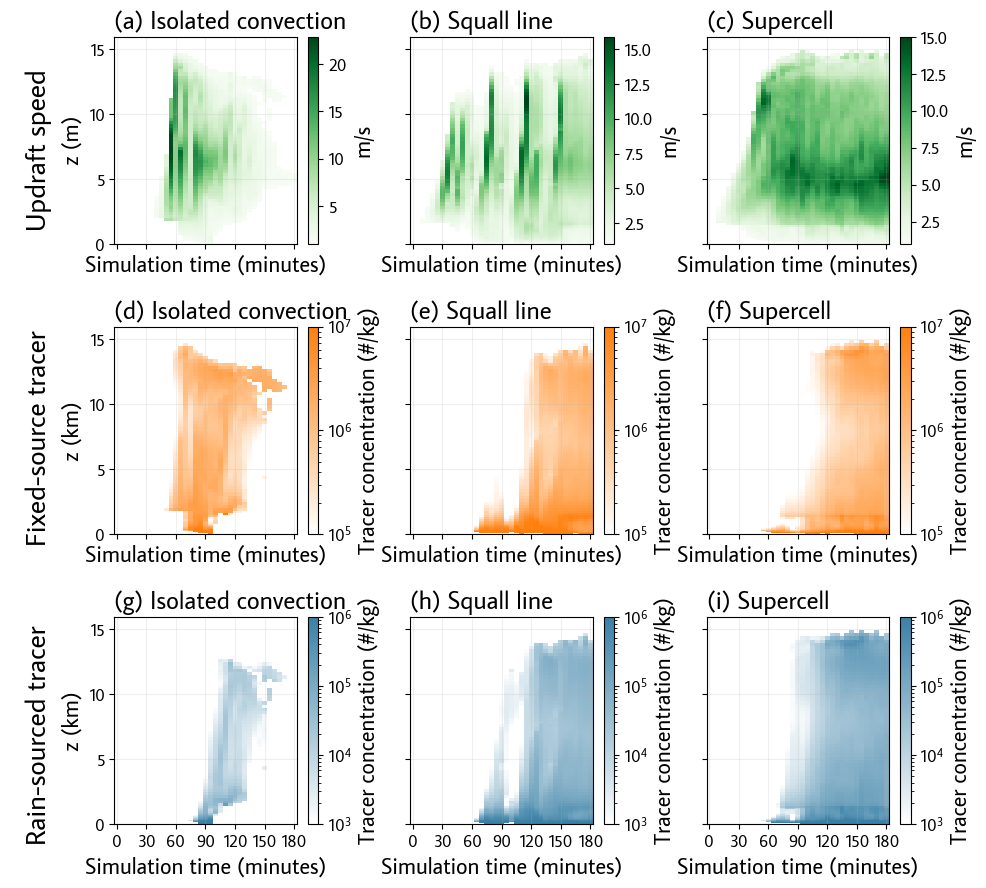

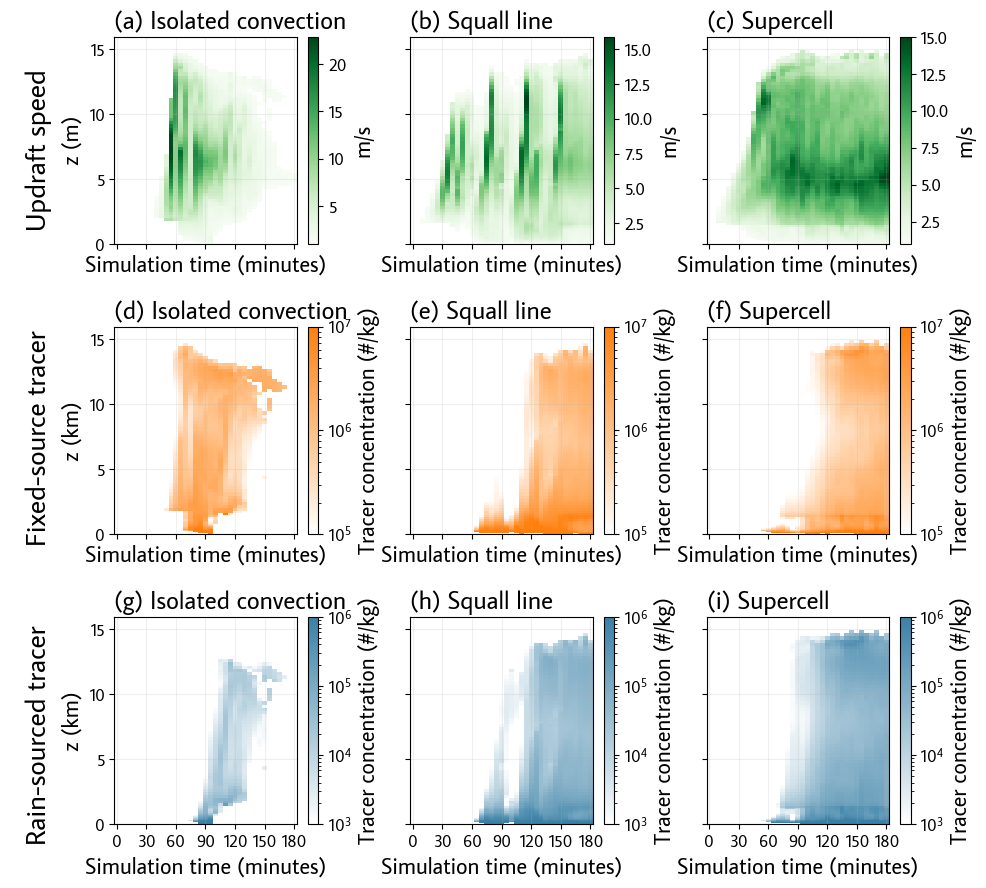

In [ ]:
# Need to run the cell above first
# Do the plotting

figure_name = "f07_tracer_profiles_vs_time"
figure_data = {}

reload(cm.plotting)

# Calculate the updraft speed profiles

updraft_speed_profiles = {}

# Mean updraft speed
for storm_ix, (storm, storm_ds) in tqdm(enumerate(storm_dss.items())):
    storm_ds = storm_ds.where(storm_ds["in_analysis"] & storm_ds["in_updraft"]).sel(
        {"z": slice(0, 16000)}
    )
    updraft_speed_profiles[storm] = (
        storm_ds["WC"].mean(["x", "y"], skipna=True).compute()
    )

fig, axs = plt.subplots(figsize=(10, 9), nrows=3, ncols=3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.13, hspace=0.4)

# Updraft speeds
for storm_ix, (storm, this_storm_ds) in enumerate(storm_dss.items()):
    ax = axs[0, storm_ix]
    updraft_artist = blt.plot_and_save(
        figure_data,
        f"storm-{storm}_max_updraft_speed",
        ax.pcolormesh,
        updraft_speed_profiles[storm]["t_minutes"].values,
        updraft_speed_profiles[storm]["z"].values,
        updraft_speed_profiles[storm].values.transpose(),
        cmap="Greens",
    )
    cbar = fig.colorbar(updraft_artist, ax=ax)
    cbar.ax.set_ylabel("m/s")
    ax.set_title(blt.axes_title(storm_ix, blt.STORM_LABELS[storm]))
    blt.label_x_axis(ax)

cm.plotting.add_row_header(
    axs[0, 0], "Updraft speed", xycoords="figure fraction", xy=(0.05, 0.82)
)
axs[0, 0].set_ylabel("z (m)")

cmap_limits = {
    0: {"ic_wk": [1e5, 1e7], "sl_wk": [1e5, 1e7], "sc_wk": [1e5, 1e7]},
    1: {"ic_wk": [1e3, 1e6], "sl_wk": [1e3, 1e6], "sc_wk": [1e3, 1e6]},
}

# Tracers
for tracer_type_ix, tracer_type in enumerate(["Fixed-source", "Rain-sourced"]):
    for storm_ix, (storm, this_tracer_ds) in enumerate(
        tracer_totals_profile_dss.items()
    ):
        this_tracer_ds = this_tracer_ds.sel({"z": slice(0, 16000)})
        ax = axs[tracer_type_ix + 1, storm_ix]
        cbar = plt.colorbar(
            blt.plot_and_save(
                figure_data,
                f"storm-{storm}_tracertype-{['fs', 'rs'][tracer_type_ix]}_nc_profile",
                ax.pcolormesh,
                this_tracer_ds["t_minutes"].values,
                this_tracer_ds["z"].values,
                (
                    (
                        this_tracer_ds["total_fs_tracer_nc"]
                        if tracer_type_ix == 0
                        else this_tracer_ds[blt.RS_TRACERS[0] + "_nc"]
                    )
                    / this_tracer_ds["air_mass"]
                ).values.transpose(),
                norm=colors.LogNorm(
                    vmin=cmap_limits[tracer_type_ix][storm][0],
                    vmax=cmap_limits[tracer_type_ix][storm][1],
                ),
                # norm=(colors.LogNorm(vmin=1e4, vmax=1e8) if metric_ix == 0 else colors.LogNorm(vmin=1e4, vmax=1e6)),
                cmap=cm.plotting.single_color_cmap(
                    cm.plotting.get_nth_color(1 if tracer_type_ix == 0 else 0)
                ),
            )
        )
        cbar.ax.set_ylabel("Tracer concentration (#/kg)")

        ax.set_title(
            blt.axes_title(3 + tracer_type_ix * 3 + storm_ix, blt.STORM_LABELS[storm])
        )
        if storm_ix == 0:
            ax.set_ylabel("z (km)")
        blt.label_x_axis(ax)
        cm.plotting.scale_axes_ticks(ax=ax, y=True, x=False, scale=1000)

    cm.plotting.add_row_header(
        axs[tracer_type_ix, 0],
        tracer_type + " tracer",
        xycoords="figure fraction",
        xy=(0.05, 0.5 - 0.33 * tracer_type_ix),
    )

blt.save_figure_data(figure_data, figure_name)
cm.plotting.fig_multisave(fig, figure_name, blt.FIGS_DIR)